# Importing libraries and initialising data


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import visualkeras 
from PIL import ImageFont
from keras.layers import *
import plotly as go
from tensorflow import keras

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Understanding CIFAR 10 dataset
**CIFAR-10 dataset** (Canadian Institute for Advanced Research) is a collection of images that are commonly used to train and benchmark image classification algorithms. It is a subset of 80 million tiny images dataset and consists of 60,000  color images in 10 different classes. There are 50000 training images and 10000 test images. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. 

<br>

| Label|Description
|-----------|-----------|
|0| airplane|
|1| automobile|
|2| bird|
|3| cat|
|4| deer|
|5| dog|
|6| frog|
|7| horse|
|8| ship|
|9| truck|

# Loading Data Set

In [3]:
#Load data and plot to get a quick understanding
#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# Feature engineering
>using min max normalization to scale the data  to -1 to 1 to match the output of generator.

In [4]:
from keras.utils import to_categorical

#Generator uses tanh activation so rescale 
#original images to -1 to 1 to match the output of generator.
classes = {
    0: 'Airplane',  1: 'Automobile',
    2: 'Bird',      3: 'Cat',
    4: 'Deer',      5: 'Dog',
    6: 'Frog',      7: 'Horse',
    8: 'Ship',      9: 'Truck' 
}
for i in [x_train, y_train, x_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("\n")

Shape: (50000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (50000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0


Shape: (10000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (10000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0




# EDA

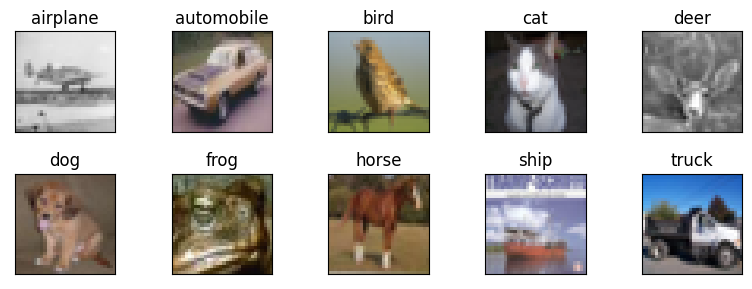

In [5]:

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.utils import plot_model, np_utils
from matplotlib import pyplot as plt
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.utils import to_categorical, plot_model
########################################################################



num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


# Trying out GAN for CIFAR-10 
> ## How do Gans Work?

>GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data. A generative adversarial network (GAN) has two parts: The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator. The discriminator learns to distinguish the generator's fake data from real data.

>![gan_image](./work_images/gan.png)


## Discriminator built

In [7]:


#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

c:\Users\Xavier\anaconda3\envs\gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
plot_model(define_discriminator())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


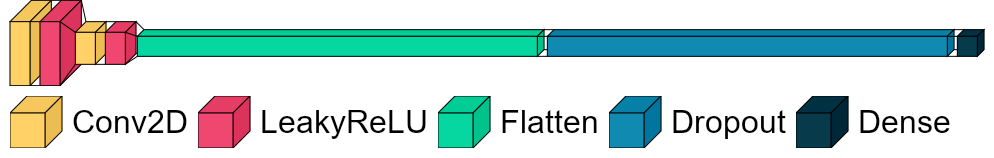

In [9]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_discriminator(), legend=True, font=font)  # font is optional!


## Generator built

In [10]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [11]:
plot_model(define_generator(latent_dim=100))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


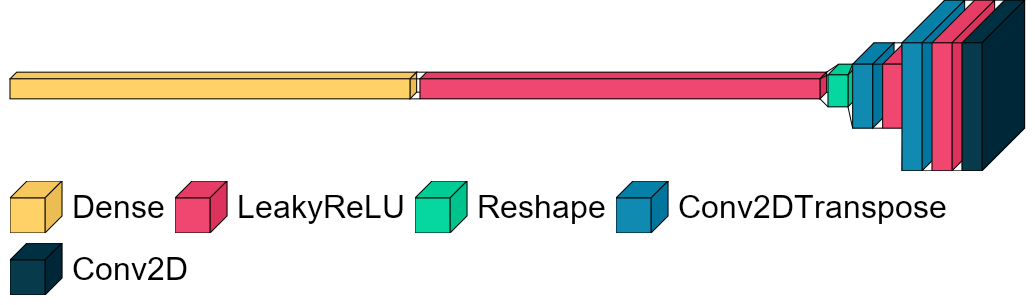

In [12]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_generator(100), legend=True, font=font)  # font is optional!


## Training the GAN

In [13]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
	

# load cifar training images
def load_real_samples():
	(x_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = x_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
   
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
			# as valid (ones)
			#This is where the generator is trying to trick discriminator into believing
			#the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		#print images for every 10th epoch
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

	# save the generator model
	g_model.save('./model/cifar_gan_test.h5')


In [14]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:

###################################################################
#Train the GAN

# size of the latent space

# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

################################################################################

# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 1/390, d1=0.644, d2=0.697 g=0.690
2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 2/390, d1=0.586, d2=0.706 g=0.681
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 3/390, d1=0.527, d2=0.722 g=0.667
2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 4/390, d1=0.481, d2=0.745 g=0.649
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 5/390, d1=0.442, d2=0.775 g=0.628
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 6/390, d1=0.378, d2=0.807 g=0.614
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch 7/390, d1=0.319, d2=0.828 g=0.611
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 8/390, d1=0.287, d2=0.822 g=0.643
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch 9/390, d1=0.303, d2=0.764 g=0.715
2/2 [==============================] - 0s 7ms/step
Epoch>1, Batch 10/390, d1=0.246, d2=0.675 g=0.814

KeyboardInterrupt: 

In [ ]:

# load model
model = load_model('./model/cifar_gan_test.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# convert to unsigned integers for viewing
X = (X*255).astype(np.uint8)


1/1 [==============================] - 5s 5s/step


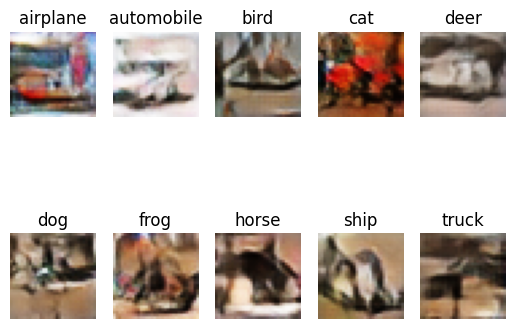

In [ ]:
# plot the result according to classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
    plt.title(classes[i])


# Definition collection

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, TerminateOnNaN, CSVLogger

from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
BATCH_SIZE = 128 #@param {type:"number"}
IMG_SIZE = (32, 32, 3) #@param {type:"number"}
def load_data_cifar():
  (x_train, y_train), (x_test, y_test) = load_data()
  train_size = 40000
  x_train, y_train, x_val, y_val = x_train[:train_size], y_train[:train_size], x_train[train_size:], y_train[train_size:]
  return x_train, y_train, x_val, y_val, x_test, y_test

def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
  x_train = x_train.astype('float32')
  x_train /= 127.5
  x_train -= 1
  
  x_val = x_val.astype('float32')
  x_val = x_val / 127.5
  x_val -= 1
  
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
  y_test = to_categorical(y_test)
  return x_train, y_train, x_val, y_val, x_test, y_test

def plot_loss_curve(model_history):
  model_history = pd.DataFrame(model_history)
  epochs = list(range(1, len(model_history) + 1))
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs, y=model_history["loss"],
                    mode='lines+markers',
                    name='Training Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_loss"],
                    mode='lines+markers',
                    name='Validation Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["accuracy"],
                    mode="lines+markers",
                    name="Training Accuracy"))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_accuracy"],
                           mode="lines+markers",
                           name="Validation Accuracy"))
  fig.update_layout(
    title="Loss/Acc Plot",
    xaxis_title="Epochs",
    yaxis_title="Loss/Acc",
)

  return fig
def basic_data_aug(images):
 image = random_flip_left_right(images) 
 image = resize_with_crop_or_pad(image, IMG_SIZE[0] + 4, IMG_SIZE[1] + 4)
 image = random_crop(
     image, size=IMG_SIZE
 )
 return image

def set_up_data_aug(x_train,y_train,x_val,y_val,aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "./model/experiments"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
    
    #training_data = train_ds, validation_data = val_ds, hyperparameters =base_hparams
  def evaluate_model(self, model, training_data, validation_data, hyperparameters , callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    try:
      if validation_data is None:
        x_train, y_train = training_data
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")
    
class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "./data_aug"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
    
    #evaluate_model params (training_data = train_ds, validation_data = val_ds, hyperparameters = base_hparams) 
    
  def evaluate_model(self, model, training_data , validation_data , hyperparameters , callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    try:
      if validation_data is None:
        X_train, y_train = training_data
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")


# Tuning
* Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
* Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
* Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
* Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.
* Experience Replay 

# Measure Performance
How do you capture the difference between two distributions in GAN loss functions? This question is an area of active research, and many approaches have been proposed. We'll address two common GAN loss functions here, both of which are implemented in TF-GAN:

* minimax loss: The loss function used in the paper that introduced GANs.
* Wasserstein loss: The default loss function for TF-GAN Estimators. First described in a 2017 paper.
* FID scores
  
TF-GAN implements many other loss functions as well.

# Trying out CGAN
>In cGANs, a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information.

* By providing additional information, we get two benefits:

* Convergence will be faster. Even the random distribution that the fake images follow will have some pattern.
* You can control the output of the generator at test time by giving the label for the image you want to generate.

## Defining hyperparameters and loading data

In [7]:
# Hyperparameters and Constants
latent_dim = 128
channels = 3
nclasses = 10
img_shape = (32, 32, 3)
discriminator_in_channels = 13

In [8]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

## Building Generator


In [9]:
# latent noise vector z
from keras.layers import *
z = Input(shape=(128,), name="Latent_Noise_Vector_z")

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

# Generator network
merged_layer = Concatenate()([z, conditions])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

base_generator = Sequential([
    # Conv 1: 4x4x256
    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 2: 8x8x128
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 3: 16x16x64
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Generator')
generator = base_generator(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', name='Output_Layer')(generator)

generator = Model(inputs=[z, conditions], outputs=generator, name='generator')

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

In [22]:
plot_model(generator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Building Discriminator

In [10]:
# input image
img_input = Input(shape=(x_train[0].shape), name='Image_Input')

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

base_discriminator = Sequential([
    # 16x16x64
    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 8x8x128
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 4x4x256
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 2x2x512
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Discriminator')
discriminator = base_discriminator(img_input)

# Feature Extraction via GAP: 512
discriminator = GlobalAveragePooling2D()(discriminator)

# Concatenate - combine with conditions y
merged_layer = Concatenate()([discriminator, conditions])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid', name='Output_Layer')(discriminator)

discriminator = Model(inputs=[img_input, conditions], outputs=discriminator, name='discriminator')

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Base_Discriminator (Sequential  (None, 2, 2, 512)   2760384     ['Image_Input[0][0]']            
 )                                                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['Base_Discriminator[0][0]']     
 alAveragePooling2D)                                                                              
                                                                                      

In [24]:
plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Building CGAN

In [11]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data
        
        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator([combined_images, combined_condition])
            d_loss = self.loss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])        
            g_loss = self.loss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

## Creating a call-back function

In [12]:
import keras 
latent_dim = 128
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=20, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax


        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = np.ceil(self.num_img/5)
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(int(row_size), 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(classes[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/cgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

# Creating a cGAN class
cond_gan = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Training the model without data augmentation

1/1 [==============================] - 0s 460ms/step


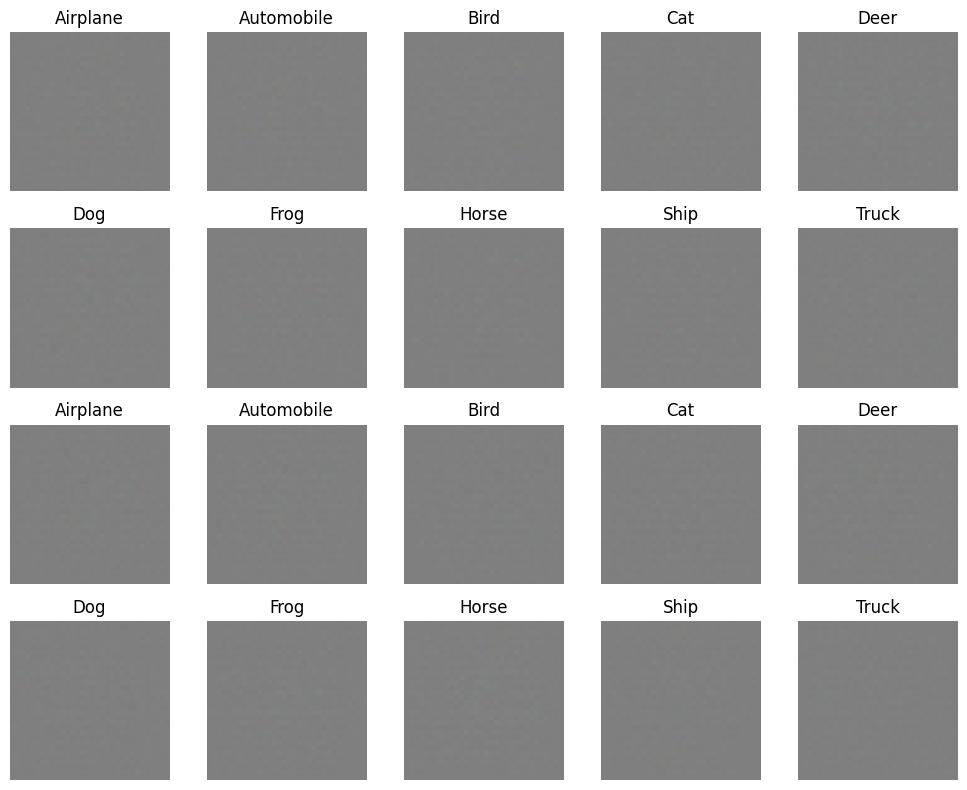

Generator Checkpoint - ./model/cgan/generator-epoch-0.h5
Epoch 1/100
625/625 [==============================] - 33s 45ms/step - d_loss: 0.4153 - g_loss: 2.1852 - D(x|y): 0.5596 - D(G(z|y)): 0.1987 - KL Divergence: 5.6771
Epoch 2/100
625/625 [==============================] - 28s 45ms/step - d_loss: 0.2749 - g_loss: 3.1019 - D(x|y): 0.5021 - D(G(z|y)): 0.0768 - KL Divergence: 5.3651
Epoch 3/100
625/625 [==============================] - 29s 46ms/step - d_loss: 0.2260 - g_loss: 3.4463 - D(x|y): 0.5057 - D(G(z|y)): 0.0549 - KL Divergence: 5.3288
Epoch 4/100
625/625 [==============================] - 29s 46ms/step - d_loss: 0.3002 - g_loss: 2.8174 - D(x|y): 0.5016 - D(G(z|y)): 0.0945 - KL Divergence: 5.8555
Epoch 5/100
1/1 [==============================] - 0s 31ms/step


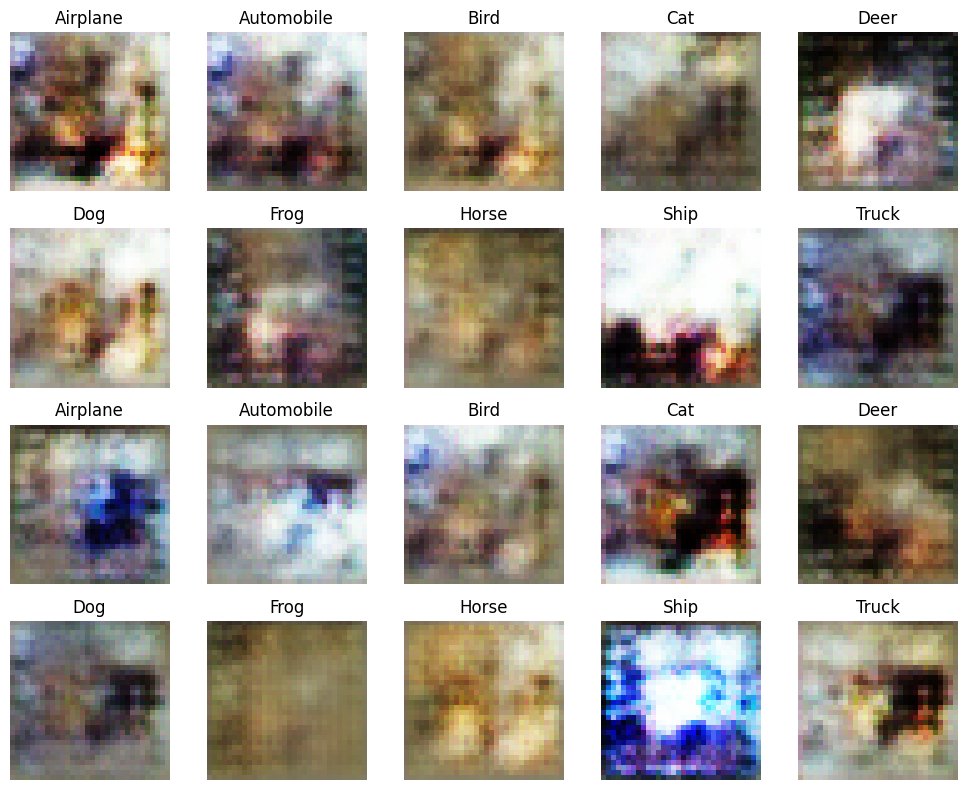

Generator Checkpoint - ./model/cgan/generator-epoch-5.h5
Epoch 6/100
625/625 [==============================] - 29s 46ms/step - d_loss: 0.2383 - g_loss: 3.3156 - D(x|y): 0.5000 - D(G(z|y)): 0.0598 - KL Divergence: 5.0389
Epoch 7/100
625/625 [==============================] - 29s 47ms/step - d_loss: 0.2258 - g_loss: 3.3449 - D(x|y): 0.4996 - D(G(z|y)): 0.0624 - KL Divergence: 4.9179
Epoch 8/100
625/625 [==============================] - 30s 47ms/step - d_loss: 0.2419 - g_loss: 3.0631 - D(x|y): 0.5011 - D(G(z|y)): 0.0819 - KL Divergence: 5.1620
Epoch 9/100
625/625 [==============================] - 30s 48ms/step - d_loss: 0.2366 - g_loss: 3.2894 - D(x|y): 0.4999 - D(G(z|y)): 0.0831 - KL Divergence: 5.0691
Epoch 10/100
1/1 [==============================] - 0s 29ms/step


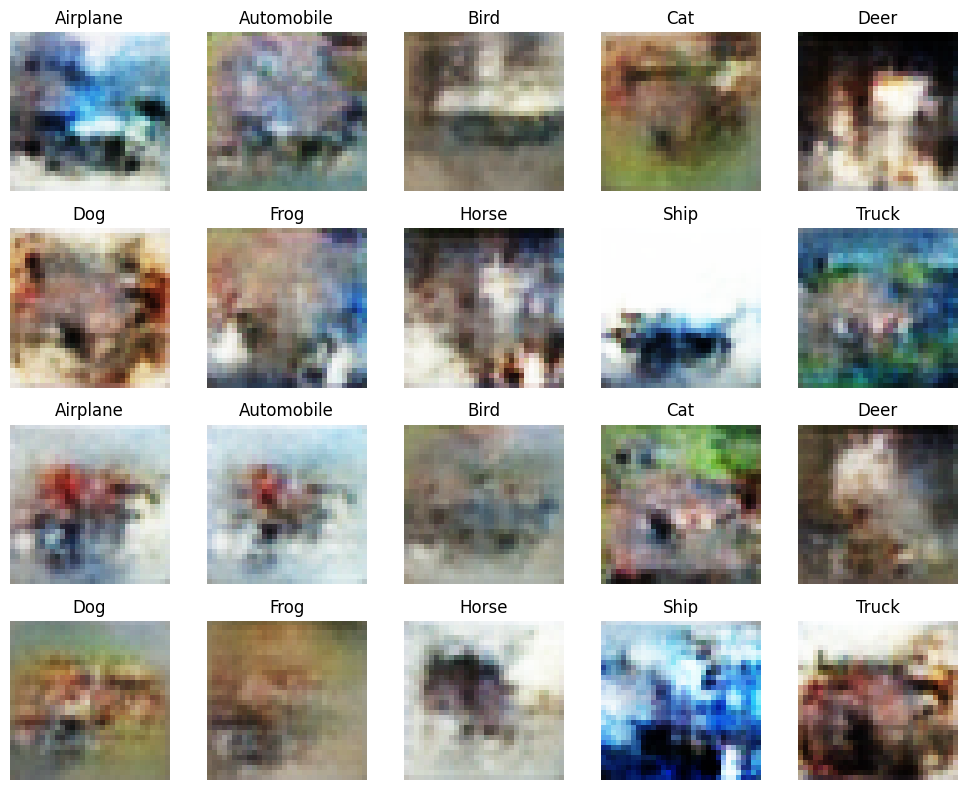

Generator Checkpoint - ./model/cgan/generator-epoch-10.h5
Epoch 11/100
625/625 [==============================] - 30s 48ms/step - d_loss: 0.2245 - g_loss: 3.3894 - D(x|y): 0.4998 - D(G(z|y)): 0.0815 - KL Divergence: 4.7743
Epoch 12/100
625/625 [==============================] - 30s 48ms/step - d_loss: 0.2288 - g_loss: 3.3141 - D(x|y): 0.4996 - D(G(z|y)): 0.0882 - KL Divergence: 4.8093
Epoch 13/100
625/625 [==============================] - 31s 49ms/step - d_loss: 0.2229 - g_loss: 3.3539 - D(x|y): 0.5005 - D(G(z|y)): 0.0895 - KL Divergence: 5.0601
Epoch 14/100
625/625 [==============================] - 30s 49ms/step - d_loss: 0.2316 - g_loss: 3.3151 - D(x|y): 0.4992 - D(G(z|y)): 0.0948 - KL Divergence: 4.9438
Epoch 15/100
1/1 [==============================] - 0s 27ms/step


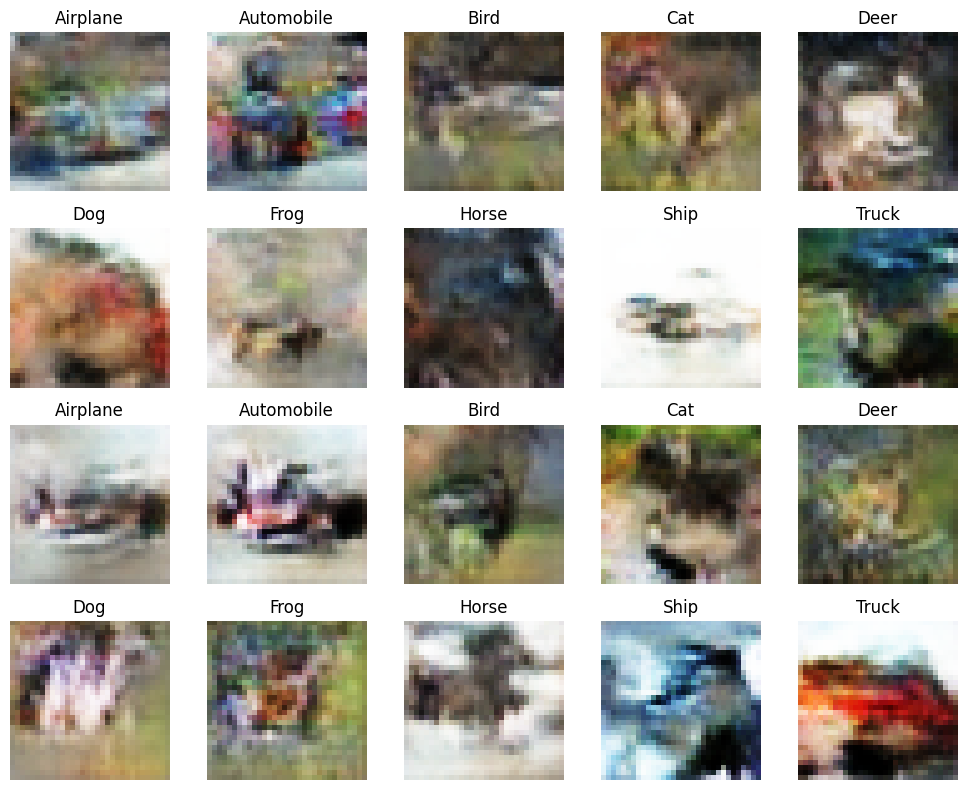

Generator Checkpoint - ./model/cgan/generator-epoch-15.h5
Epoch 16/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2224 - g_loss: 3.3781 - D(x|y): 0.5001 - D(G(z|y)): 0.0956 - KL Divergence: 4.7044
Epoch 17/100
625/625 [==============================] - 35s 56ms/step - d_loss: 0.2232 - g_loss: 3.3568 - D(x|y): 0.5003 - D(G(z|y)): 0.0990 - KL Divergence: 4.7135
Epoch 18/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2252 - g_loss: 3.3313 - D(x|y): 0.5003 - D(G(z|y)): 0.1032 - KL Divergence: 4.7174
Epoch 19/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2212 - g_loss: 3.2336 - D(x|y): 0.5006 - D(G(z|y)): 0.1077 - KL Divergence: 4.7690
Epoch 20/100
1/1 [==============================] - 0s 33ms/step


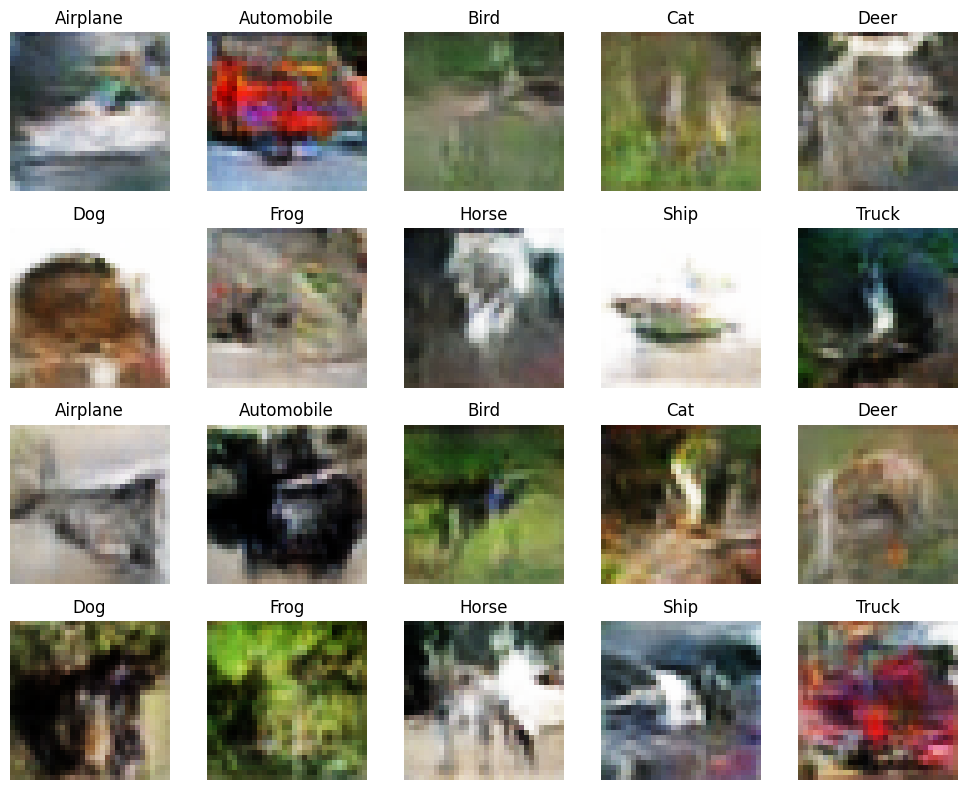

Generator Checkpoint - ./model/cgan/generator-epoch-20.h5
Epoch 21/100
625/625 [==============================] - 31s 49ms/step - d_loss: 0.2078 - g_loss: 3.4173 - D(x|y): 0.5002 - D(G(z|y)): 0.1030 - KL Divergence: 4.6284
Epoch 22/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2066 - g_loss: 3.4300 - D(x|y): 0.5004 - D(G(z|y)): 0.1066 - KL Divergence: 4.5543
Epoch 23/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2048 - g_loss: 3.5435 - D(x|y): 0.5003 - D(G(z|y)): 0.1021 - KL Divergence: 4.4914
Epoch 24/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1929 - g_loss: 3.6223 - D(x|y): 0.4994 - D(G(z|y)): 0.0997 - KL Divergence: 4.6181
Epoch 25/100
1/1 [==============================] - 0s 29ms/step


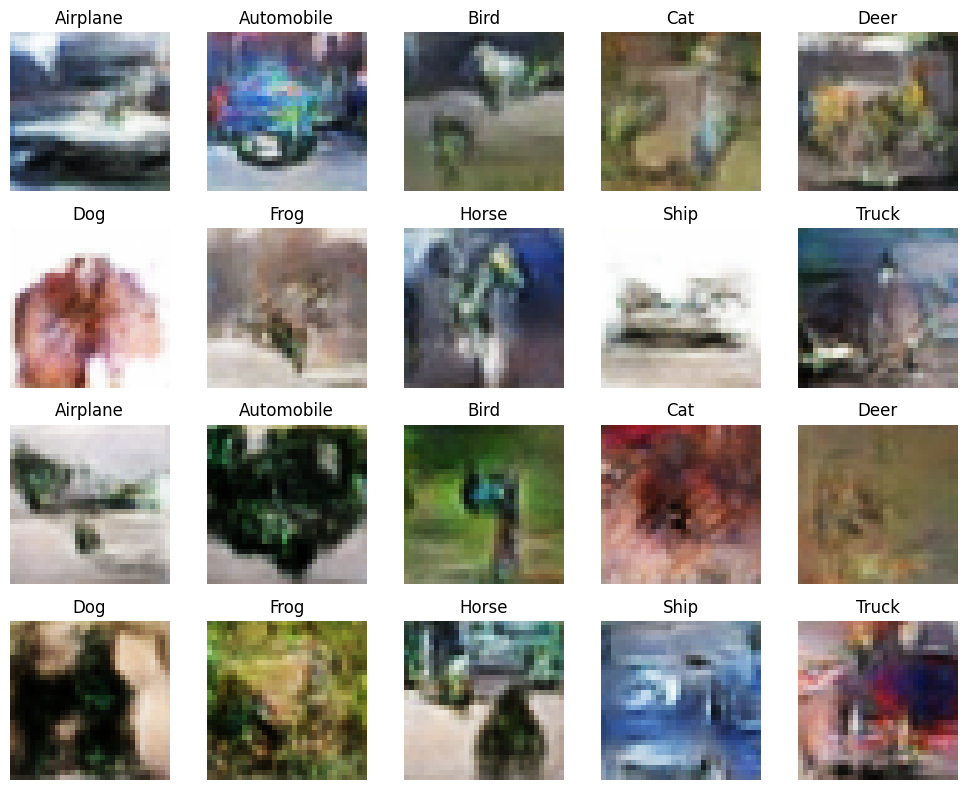

Generator Checkpoint - ./model/cgan/generator-epoch-25.h5
Epoch 26/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1998 - g_loss: 3.5709 - D(x|y): 0.5007 - D(G(z|y)): 0.1104 - KL Divergence: 4.4437
Epoch 27/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2046 - g_loss: 3.6293 - D(x|y): 0.5008 - D(G(z|y)): 0.1098 - KL Divergence: 4.4503
Epoch 28/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1739 - g_loss: 3.9484 - D(x|y): 0.4999 - D(G(z|y)): 0.0979 - KL Divergence: 4.5013
Epoch 29/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1733 - g_loss: 4.1216 - D(x|y): 0.5000 - D(G(z|y)): 0.0926 - KL Divergence: 4.6410
Epoch 30/100
1/1 [==============================] - 0s 33ms/step


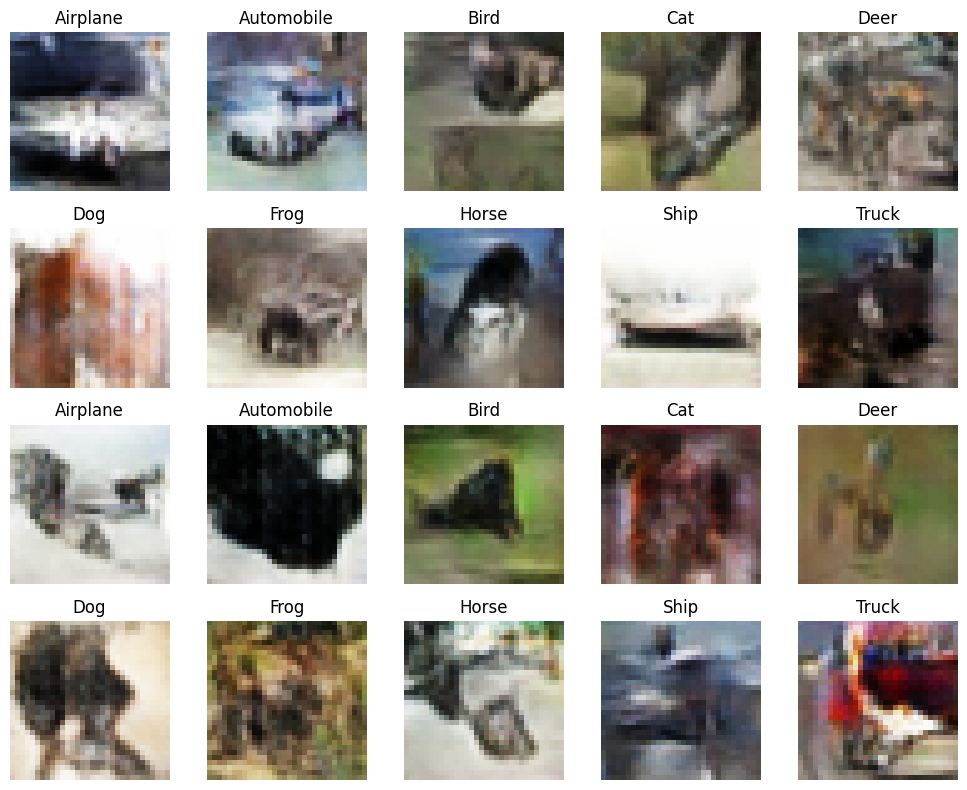

Generator Checkpoint - ./model/cgan/generator-epoch-30.h5
Epoch 31/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1528 - g_loss: 4.4640 - D(x|y): 0.5005 - D(G(z|y)): 0.0833 - KL Divergence: 4.7338
Epoch 32/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1468 - g_loss: 4.6381 - D(x|y): 0.5002 - D(G(z|y)): 0.0791 - KL Divergence: 4.7161
Epoch 33/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1442 - g_loss: 4.7909 - D(x|y): 0.5005 - D(G(z|y)): 0.0787 - KL Divergence: 4.6626
Epoch 34/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.1433 - g_loss: 4.9312 - D(x|y): 0.5001 - D(G(z|y)): 0.0757 - KL Divergence: 4.5040
Epoch 35/100
1/1 [==============================] - 0s 30ms/step


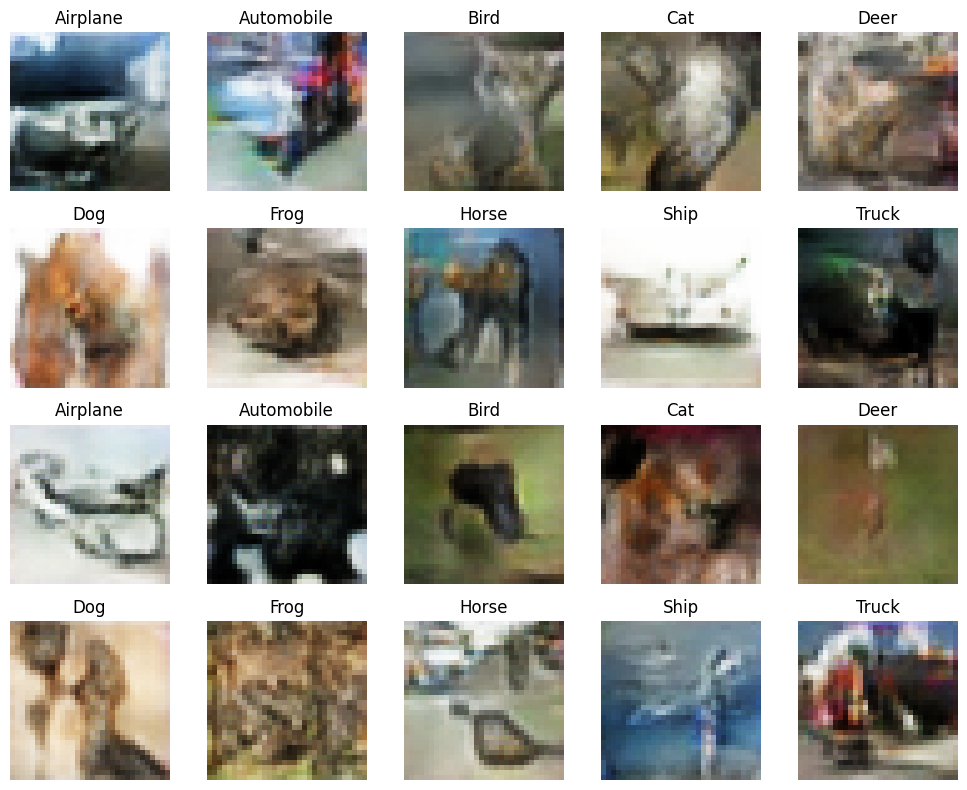

Generator Checkpoint - ./model/cgan/generator-epoch-35.h5
Epoch 36/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1297 - g_loss: 5.1809 - D(x|y): 0.4997 - D(G(z|y)): 0.0685 - KL Divergence: 4.5300
Epoch 37/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1316 - g_loss: 5.2889 - D(x|y): 0.5002 - D(G(z|y)): 0.0707 - KL Divergence: 4.6656
Epoch 38/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1207 - g_loss: 5.3575 - D(x|y): 0.4998 - D(G(z|y)): 0.0688 - KL Divergence: 4.5623
Epoch 39/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1226 - g_loss: 5.5111 - D(x|y): 0.4995 - D(G(z|y)): 0.0668 - KL Divergence: 4.6837
Epoch 40/100
1/1 [==============================] - 0s 35ms/step


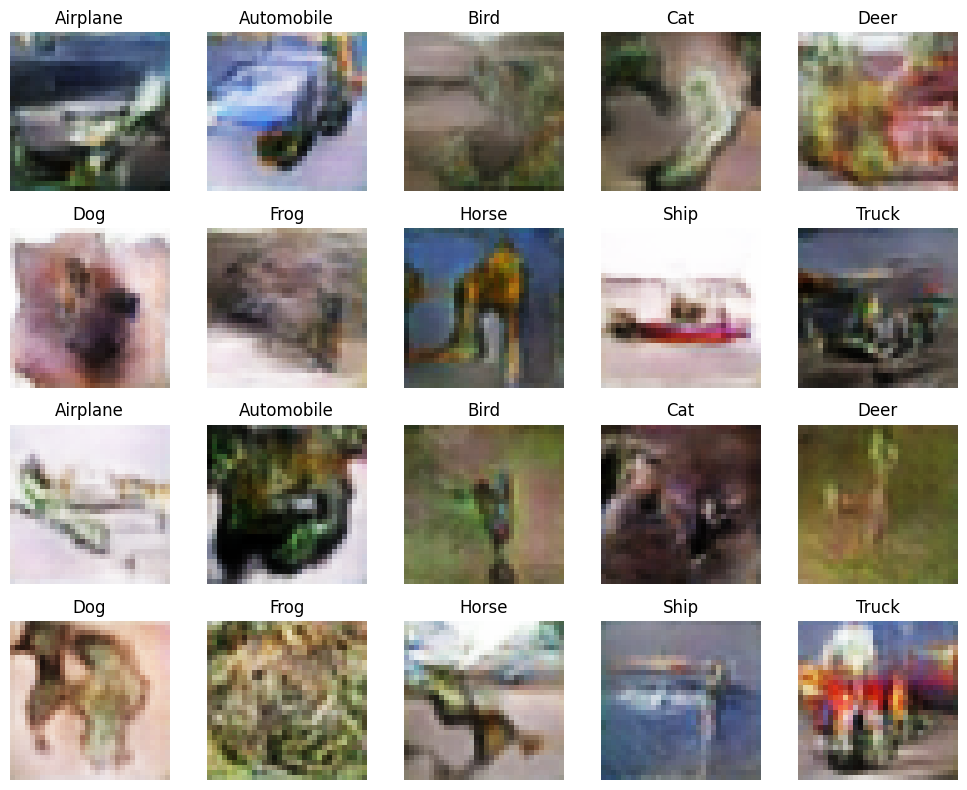

Generator Checkpoint - ./model/cgan/generator-epoch-40.h5
Epoch 41/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1170 - g_loss: 5.7043 - D(x|y): 0.4996 - D(G(z|y)): 0.0621 - KL Divergence: 4.5868
Epoch 42/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1122 - g_loss: 5.8212 - D(x|y): 0.4999 - D(G(z|y)): 0.0600 - KL Divergence: 4.5421
Epoch 43/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1129 - g_loss: 5.9580 - D(x|y): 0.5006 - D(G(z|y)): 0.0583 - KL Divergence: 4.5251
Epoch 44/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1100 - g_loss: 6.0669 - D(x|y): 0.5002 - D(G(z|y)): 0.0576 - KL Divergence: 4.6509
Epoch 45/100
1/1 [==============================] - 0s 38ms/step


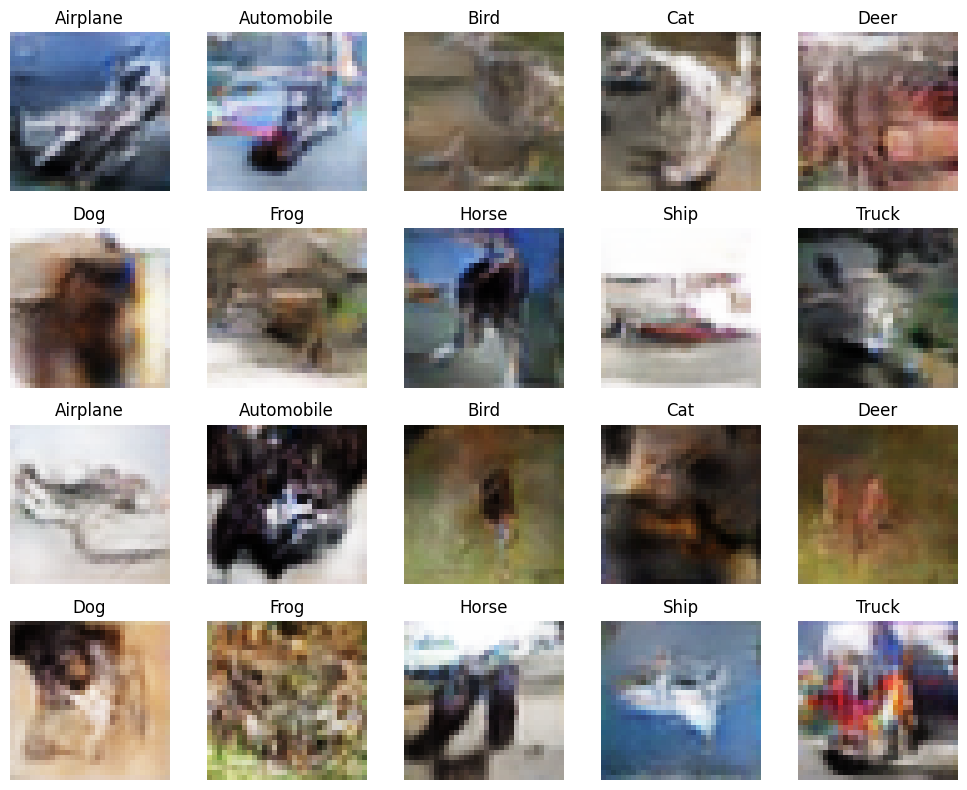

Generator Checkpoint - ./model/cgan/generator-epoch-45.h5
Epoch 46/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1040 - g_loss: 6.1827 - D(x|y): 0.4999 - D(G(z|y)): 0.0550 - KL Divergence: 4.7012
Epoch 47/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1022 - g_loss: 6.2686 - D(x|y): 0.5004 - D(G(z|y)): 0.0538 - KL Divergence: 4.6287
Epoch 48/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.1051 - g_loss: 6.2424 - D(x|y): 0.5000 - D(G(z|y)): 0.0579 - KL Divergence: 4.5647
Epoch 49/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0980 - g_loss: 6.3625 - D(x|y): 0.4999 - D(G(z|y)): 0.0546 - KL Divergence: 4.6842
Epoch 50/100
1/1 [==============================] - 0s 33ms/step


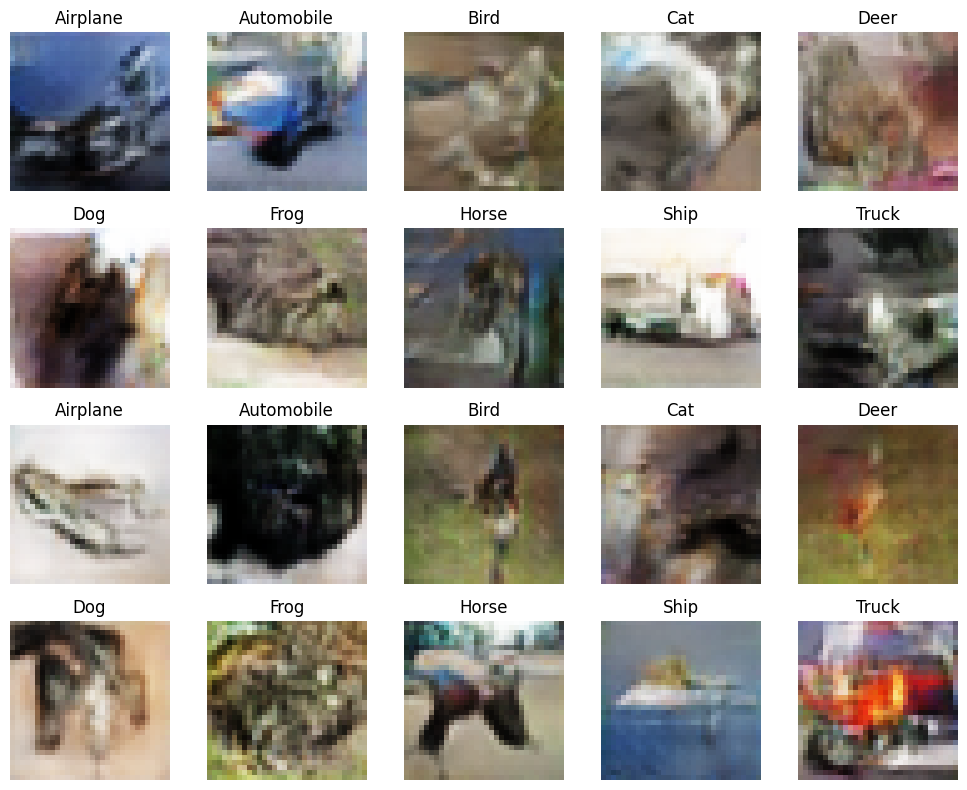

Generator Checkpoint - ./model/cgan/generator-epoch-50.h5
Epoch 51/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0959 - g_loss: 6.4481 - D(x|y): 0.5002 - D(G(z|y)): 0.0509 - KL Divergence: 4.6191
Epoch 52/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.0954 - g_loss: 6.6590 - D(x|y): 0.4999 - D(G(z|y)): 0.0522 - KL Divergence: 4.6082
Epoch 53/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.0904 - g_loss: 6.6519 - D(x|y): 0.4999 - D(G(z|y)): 0.0514 - KL Divergence: 4.5443
Epoch 54/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0928 - g_loss: 6.7301 - D(x|y): 0.5005 - D(G(z|y)): 0.0481 - KL Divergence: 4.6329
Epoch 55/100
1/1 [==============================] - 0s 39ms/step


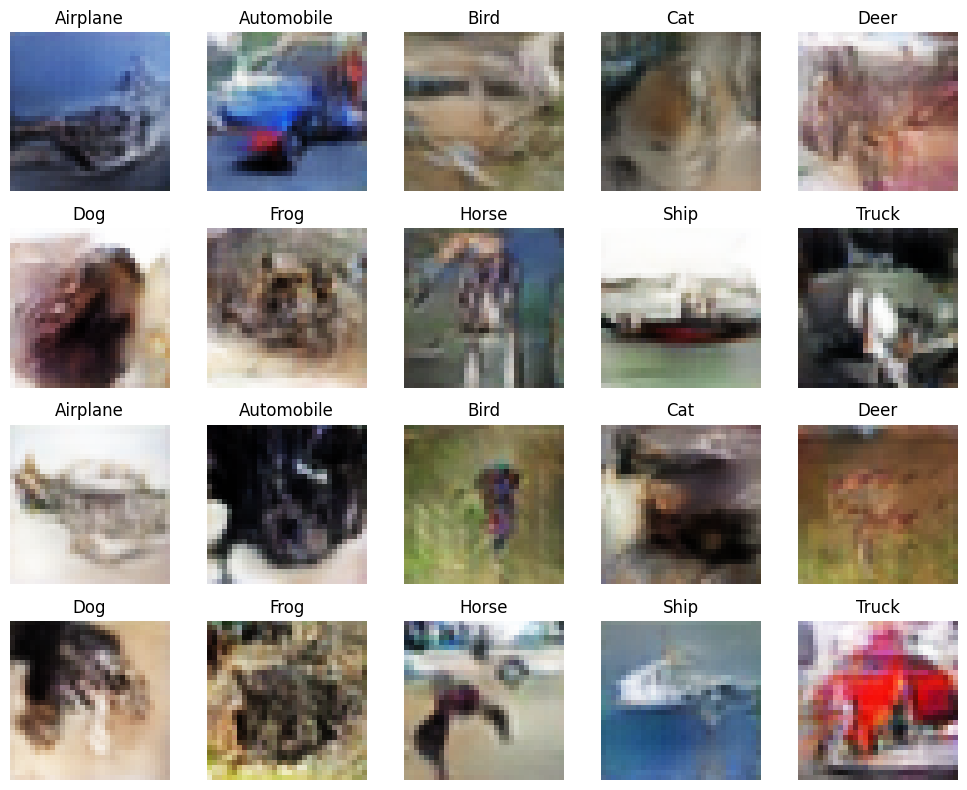

Generator Checkpoint - ./model/cgan/generator-epoch-55.h5
Epoch 56/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0900 - g_loss: 6.9119 - D(x|y): 0.5002 - D(G(z|y)): 0.0485 - KL Divergence: 4.6227
Epoch 57/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0931 - g_loss: 7.0305 - D(x|y): 0.4996 - D(G(z|y)): 0.0464 - KL Divergence: 4.6538
Epoch 58/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0897 - g_loss: 7.0209 - D(x|y): 0.5002 - D(G(z|y)): 0.0483 - KL Divergence: 4.5879
Epoch 59/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0852 - g_loss: 7.1064 - D(x|y): 0.5000 - D(G(z|y)): 0.0469 - KL Divergence: 4.6279
Epoch 60/100
1/1 [==============================] - 0s 40ms/step


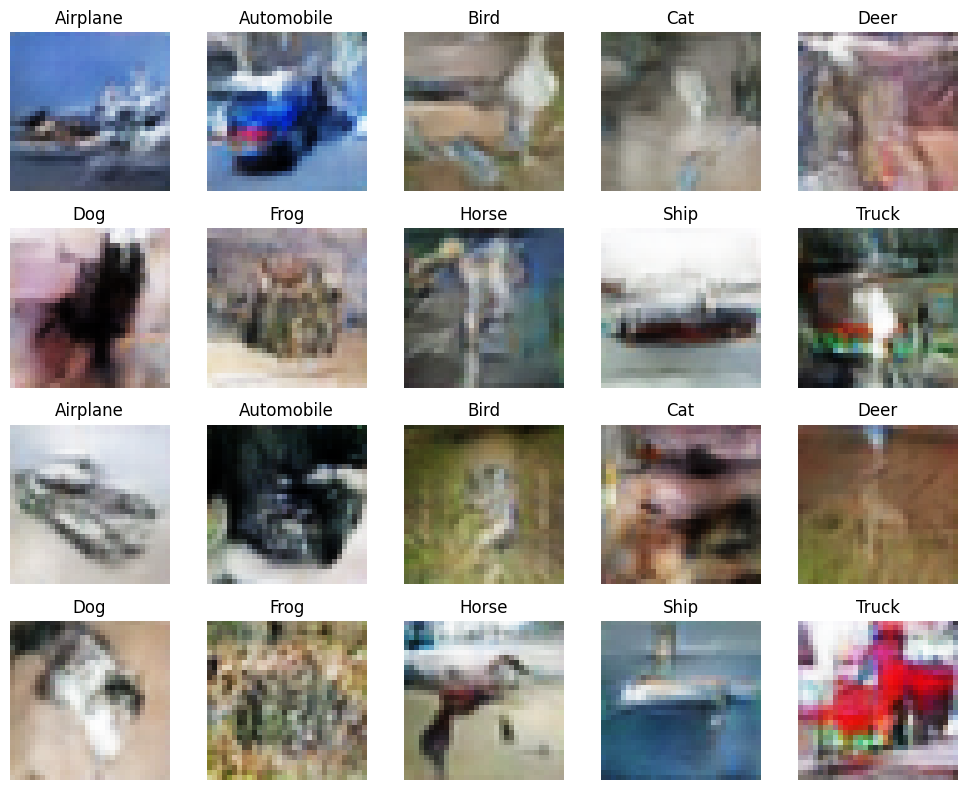

Generator Checkpoint - ./model/cgan/generator-epoch-60.h5
Epoch 61/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0842 - g_loss: 7.2956 - D(x|y): 0.4996 - D(G(z|y)): 0.0444 - KL Divergence: 4.4949
Epoch 62/100
625/625 [==============================] - 32s 50ms/step - d_loss: 0.0807 - g_loss: 7.4185 - D(x|y): 0.5001 - D(G(z|y)): 0.0433 - KL Divergence: 4.7916
Epoch 63/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0828 - g_loss: 7.4011 - D(x|y): 0.4999 - D(G(z|y)): 0.0447 - KL Divergence: 4.6523
Epoch 64/100
625/625 [==============================] - 32s 50ms/step - d_loss: 0.0765 - g_loss: 7.5581 - D(x|y): 0.4999 - D(G(z|y)): 0.0430 - KL Divergence: 4.5795
Epoch 65/100
1/1 [==============================] - 0s 32ms/step


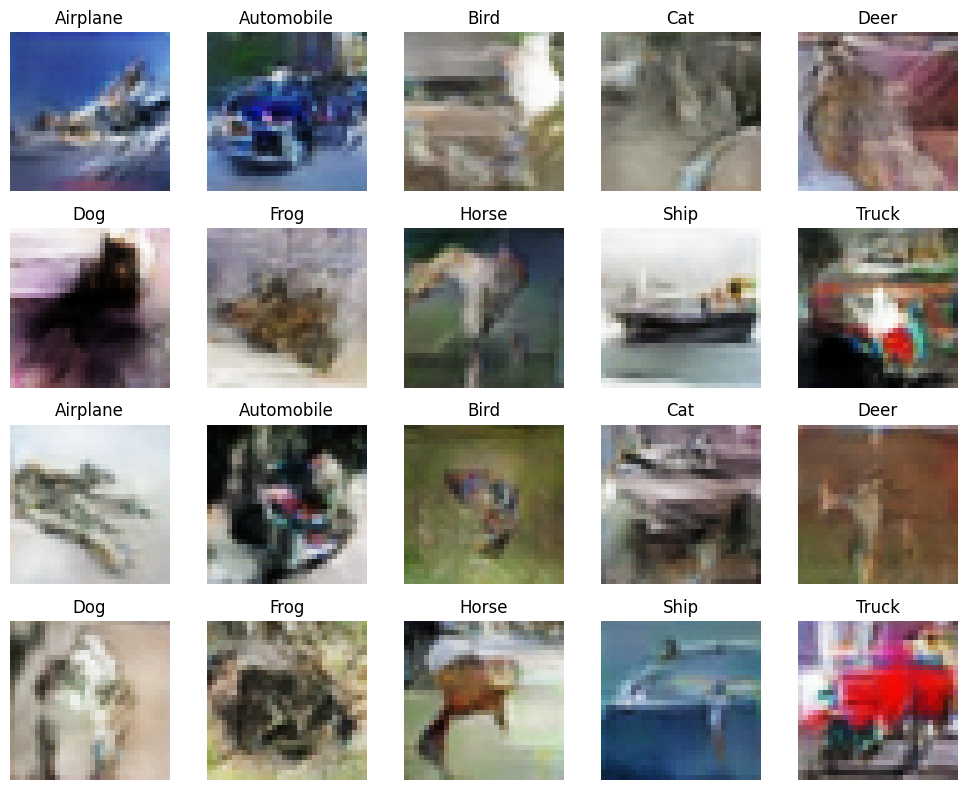

Generator Checkpoint - ./model/cgan/generator-epoch-65.h5
Epoch 66/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0732 - g_loss: 7.6654 - D(x|y): 0.5001 - D(G(z|y)): 0.0401 - KL Divergence: 4.6455
Epoch 67/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0784 - g_loss: 7.6900 - D(x|y): 0.4999 - D(G(z|y)): 0.0426 - KL Divergence: 4.4721
Epoch 68/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0781 - g_loss: 7.6989 - D(x|y): 0.4997 - D(G(z|y)): 0.0402 - KL Divergence: 4.5588
Epoch 69/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0742 - g_loss: 7.6958 - D(x|y): 0.5001 - D(G(z|y)): 0.0432 - KL Divergence: 4.5219
Epoch 70/100
1/1 [==============================] - 0s 36ms/step


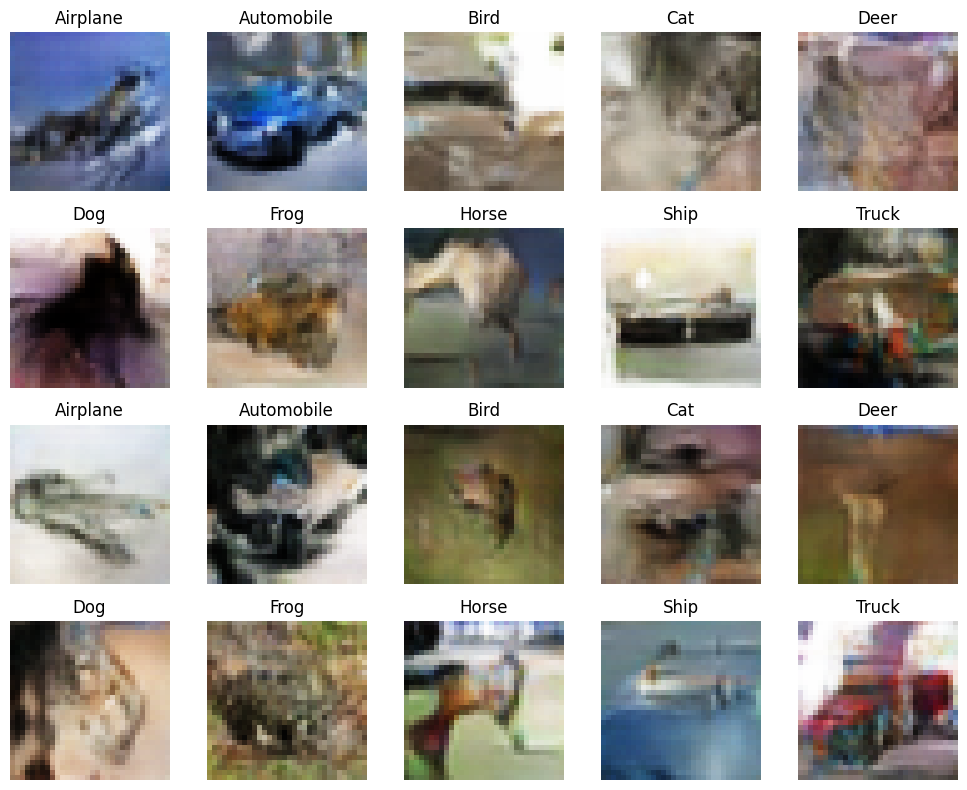

Generator Checkpoint - ./model/cgan/generator-epoch-70.h5
Epoch 71/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0718 - g_loss: 7.8353 - D(x|y): 0.5001 - D(G(z|y)): 0.0415 - KL Divergence: 4.5272
Epoch 72/100
625/625 [==============================] - 32s 50ms/step - d_loss: 0.0731 - g_loss: 7.8064 - D(x|y): 0.5000 - D(G(z|y)): 0.0406 - KL Divergence: 4.5018
Epoch 73/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0746 - g_loss: 7.9597 - D(x|y): 0.5000 - D(G(z|y)): 0.0380 - KL Divergence: 4.5025
Epoch 74/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0698 - g_loss: 8.0654 - D(x|y): 0.5000 - D(G(z|y)): 0.0385 - KL Divergence: 4.5312
Epoch 75/100
1/1 [==============================] - 0s 37ms/step


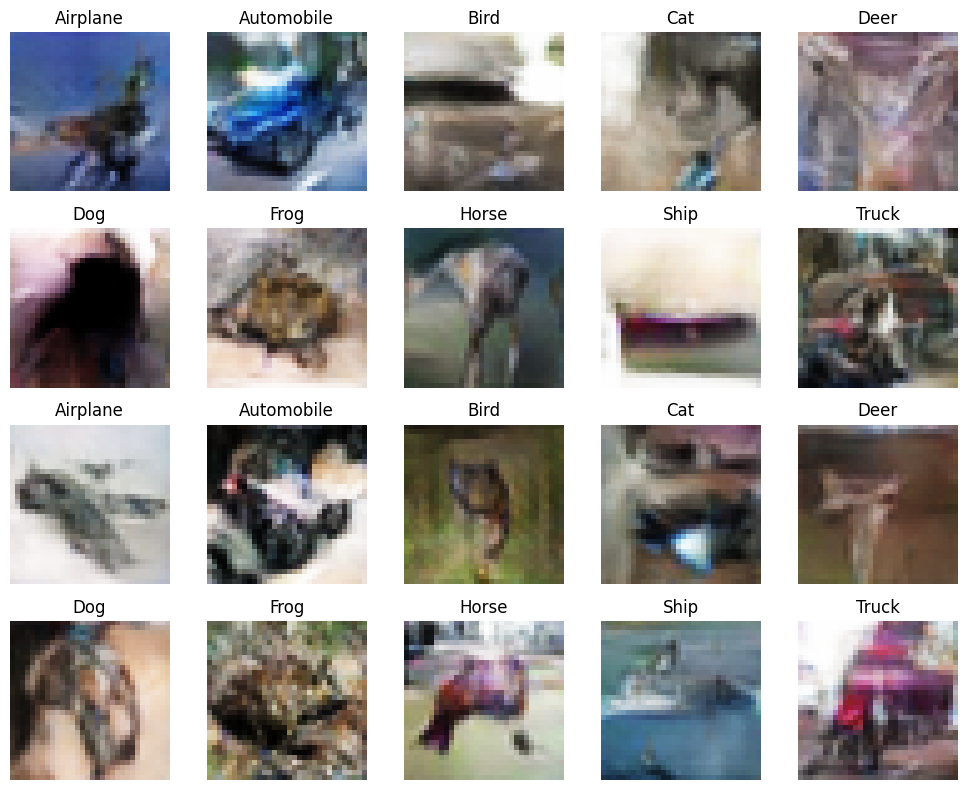

Generator Checkpoint - ./model/cgan/generator-epoch-75.h5
Epoch 76/100
625/625 [==============================] - 32s 50ms/step - d_loss: 0.0741 - g_loss: 8.0999 - D(x|y): 0.4999 - D(G(z|y)): 0.0363 - KL Divergence: 4.4400
Epoch 77/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0726 - g_loss: 8.1950 - D(x|y): 0.5001 - D(G(z|y)): 0.0374 - KL Divergence: 4.4910
Epoch 78/100
625/625 [==============================] - 32s 51ms/step - d_loss: 0.0685 - g_loss: 8.0793 - D(x|y): 0.5003 - D(G(z|y)): 0.0374 - KL Divergence: 4.5702
Epoch 79/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0676 - g_loss: 8.4067 - D(x|y): 0.5000 - D(G(z|y)): 0.0359 - KL Divergence: 4.5666
Epoch 80/100
1/1 [==============================] - 0s 30ms/step


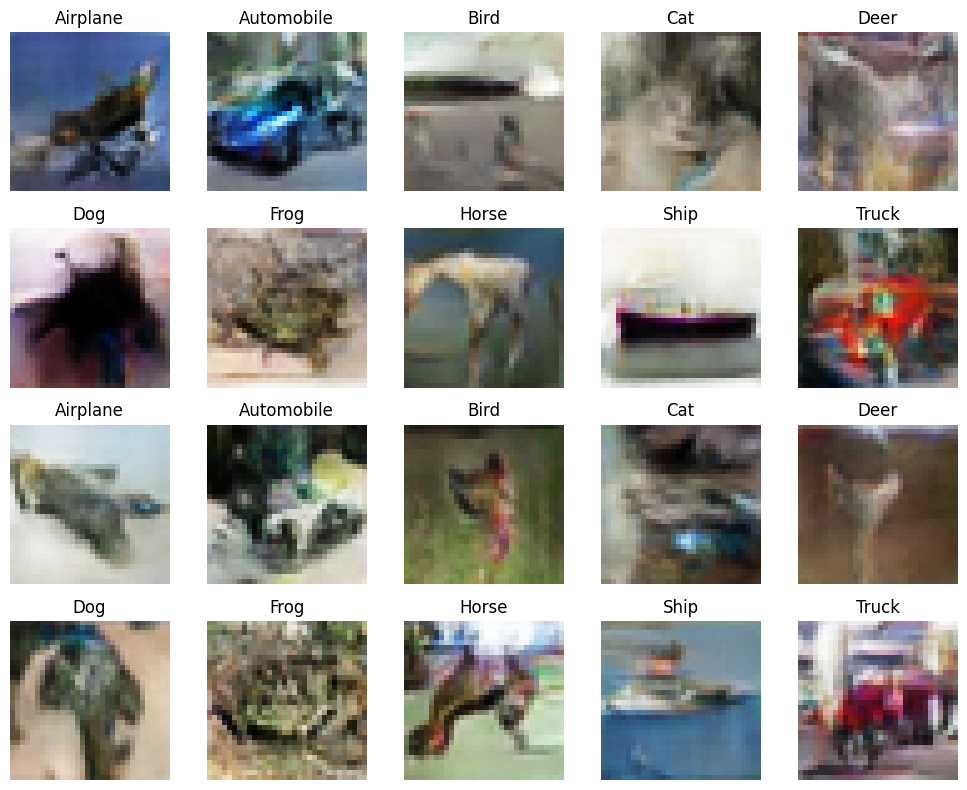

Generator Checkpoint - ./model/cgan/generator-epoch-80.h5
Epoch 81/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0673 - g_loss: 8.4008 - D(x|y): 0.4998 - D(G(z|y)): 0.0348 - KL Divergence: 4.6137
Epoch 82/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0719 - g_loss: 8.4774 - D(x|y): 0.4999 - D(G(z|y)): 0.0349 - KL Divergence: 4.5505
Epoch 83/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.0626 - g_loss: 8.3883 - D(x|y): 0.5001 - D(G(z|y)): 0.0362 - KL Divergence: 4.5170
Epoch 84/100
625/625 [==============================] - 31s 49ms/step - d_loss: 0.0654 - g_loss: 8.4420 - D(x|y): 0.5002 - D(G(z|y)): 0.0353 - KL Divergence: 4.6452
Epoch 85/100
1/1 [==============================] - 0s 219ms/step


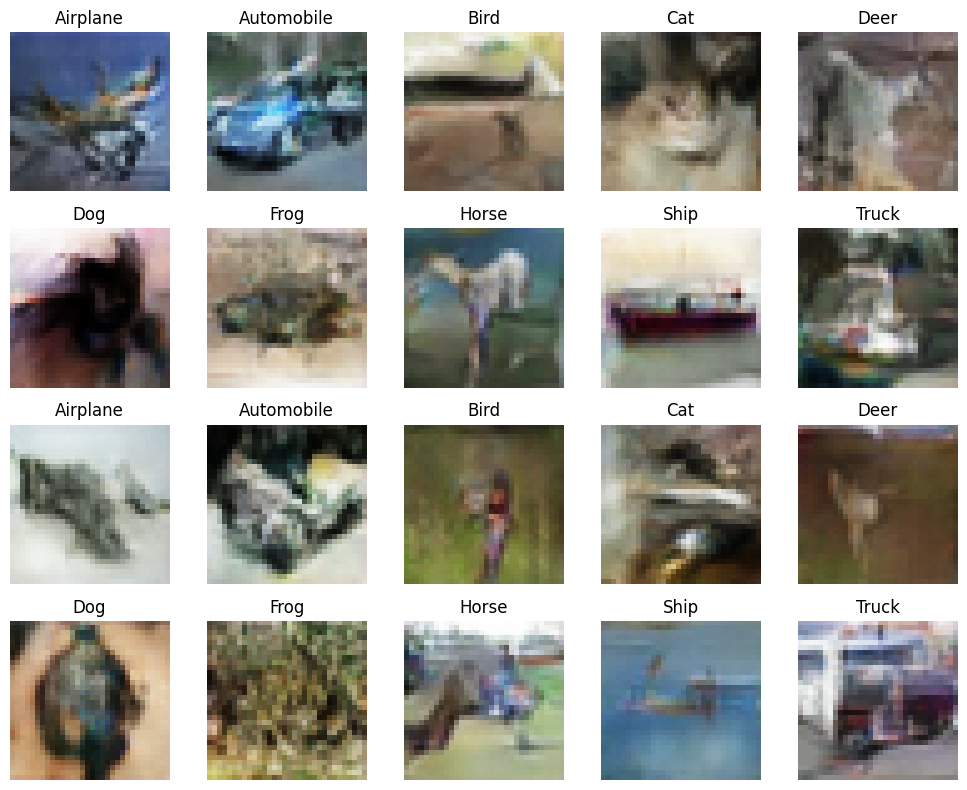

Generator Checkpoint - ./model/cgan/generator-epoch-85.h5
Epoch 86/100
625/625 [==============================] - 92s 148ms/step - d_loss: 0.0622 - g_loss: 8.7051 - D(x|y): 0.5001 - D(G(z|y)): 0.0334 - KL Divergence: 4.7288
Epoch 87/100
625/625 [==============================] - 89s 142ms/step - d_loss: 0.0645 - g_loss: 8.4270 - D(x|y): 0.5002 - D(G(z|y)): 0.0353 - KL Divergence: 4.4395
Epoch 88/100
625/625 [==============================] - 89s 143ms/step - d_loss: 0.0656 - g_loss: 8.5544 - D(x|y): 0.5004 - D(G(z|y)): 0.0339 - KL Divergence: 4.5138
Epoch 89/100
625/625 [==============================] - 88s 141ms/step - d_loss: 0.0637 - g_loss: 8.7033 - D(x|y): 0.5001 - D(G(z|y)): 0.0328 - KL Divergence: 4.6058
Epoch 90/100
1/1 [==============================] - 0s 188ms/step


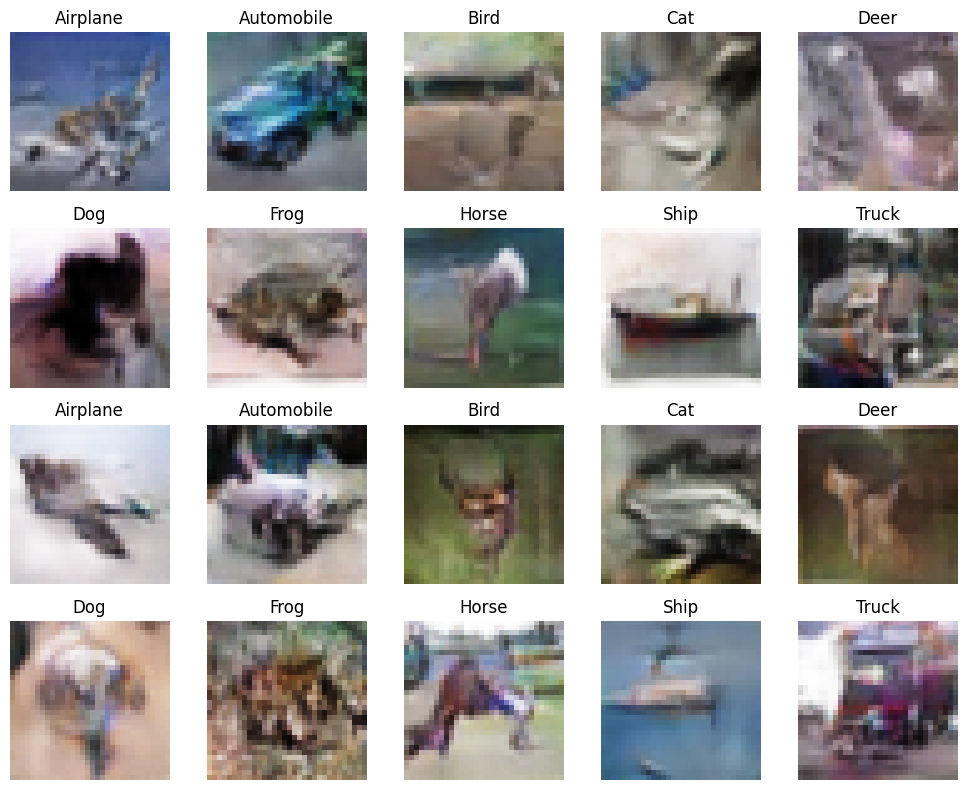

Generator Checkpoint - ./model/cgan/generator-epoch-90.h5
Epoch 91/100
625/625 [==============================] - 81s 129ms/step - d_loss: 0.0636 - g_loss: 8.8512 - D(x|y): 0.4998 - D(G(z|y)): 0.0332 - KL Divergence: 4.6035
Epoch 92/100
625/625 [==============================] - 82s 130ms/step - d_loss: 0.0588 - g_loss: 8.7779 - D(x|y): 0.5000 - D(G(z|y)): 0.0330 - KL Divergence: 4.7225
Epoch 93/100
625/625 [==============================] - 84s 135ms/step - d_loss: 0.0596 - g_loss: 8.9538 - D(x|y): 0.4999 - D(G(z|y)): 0.0310 - KL Divergence: 4.9023
Epoch 94/100
625/625 [==============================] - 84s 135ms/step - d_loss: 0.0607 - g_loss: 8.8845 - D(x|y): 0.4999 - D(G(z|y)): 0.0304 - KL Divergence: 4.7239
Epoch 95/100
1/1 [==============================] - 0s 176ms/step


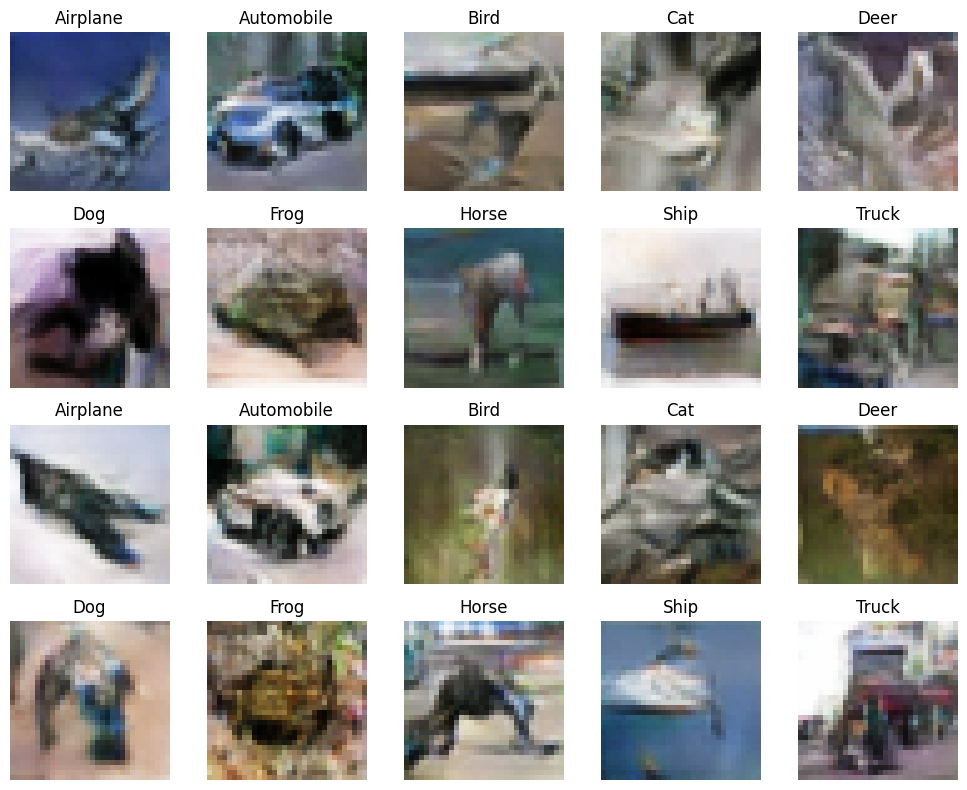

Generator Checkpoint - ./model/cgan/generator-epoch-95.h5
Epoch 96/100
625/625 [==============================] - 78s 125ms/step - d_loss: 0.0570 - g_loss: 8.9572 - D(x|y): 0.5003 - D(G(z|y)): 0.0300 - KL Divergence: 4.6696
Epoch 97/100
625/625 [==============================] - 84s 135ms/step - d_loss: 0.0585 - g_loss: 8.9176 - D(x|y): 0.5000 - D(G(z|y)): 0.0321 - KL Divergence: 4.7039
Epoch 98/100
625/625 [==============================] - 81s 129ms/step - d_loss: 0.0534 - g_loss: 9.1880 - D(x|y): 0.5000 - D(G(z|y)): 0.0294 - KL Divergence: 4.5288
Epoch 99/100
625/625 [==============================] - 31s 49ms/step - d_loss: 0.0578 - g_loss: 8.9066 - D(x|y): 0.5002 - D(G(z|y)): 0.0310 - KL Divergence: 4.7438
Epoch 100/100
1/1 [==============================] - 0s 33ms/step


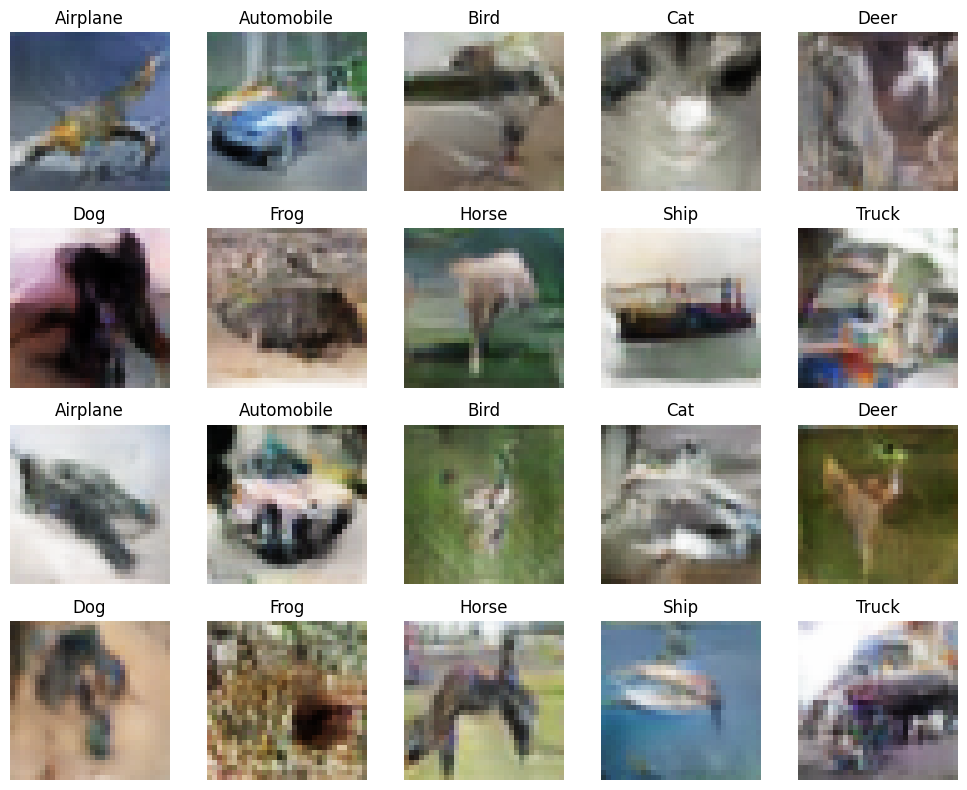

Generator Checkpoint - ./model/cgan/generator-epoch-Full Train.h5


In [27]:

# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

### Plotting the results

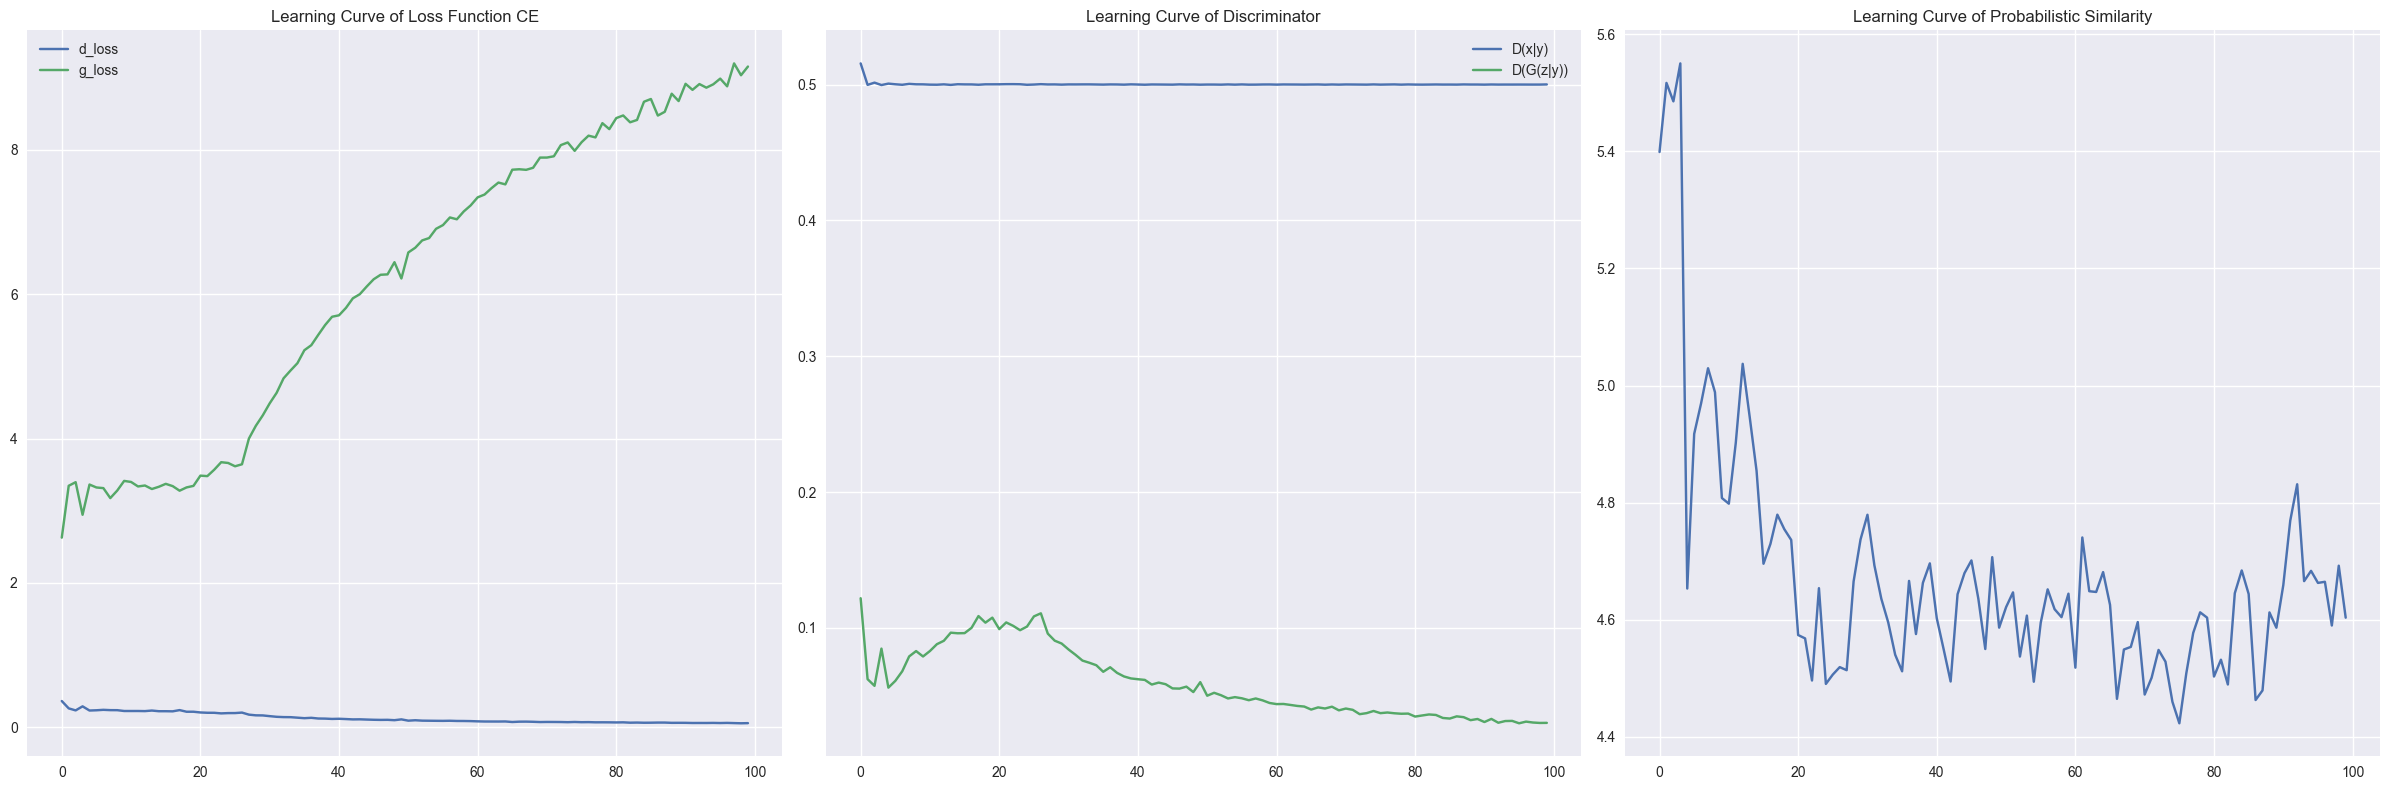

In [28]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

### Evaluation of full trainned model

In [30]:
# Loading Weights for best Generator
saved_weights = './model/cgan/generator-epoch-Full Train.h5'
cond_gan.generator.load_weights(saved_weights)
cond_gan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

32/32 [==============================] - 0s 5ms/step
Latent Vector Dim: (1024, 128)	Generated Images Dim: (1024, 32, 32, 3)


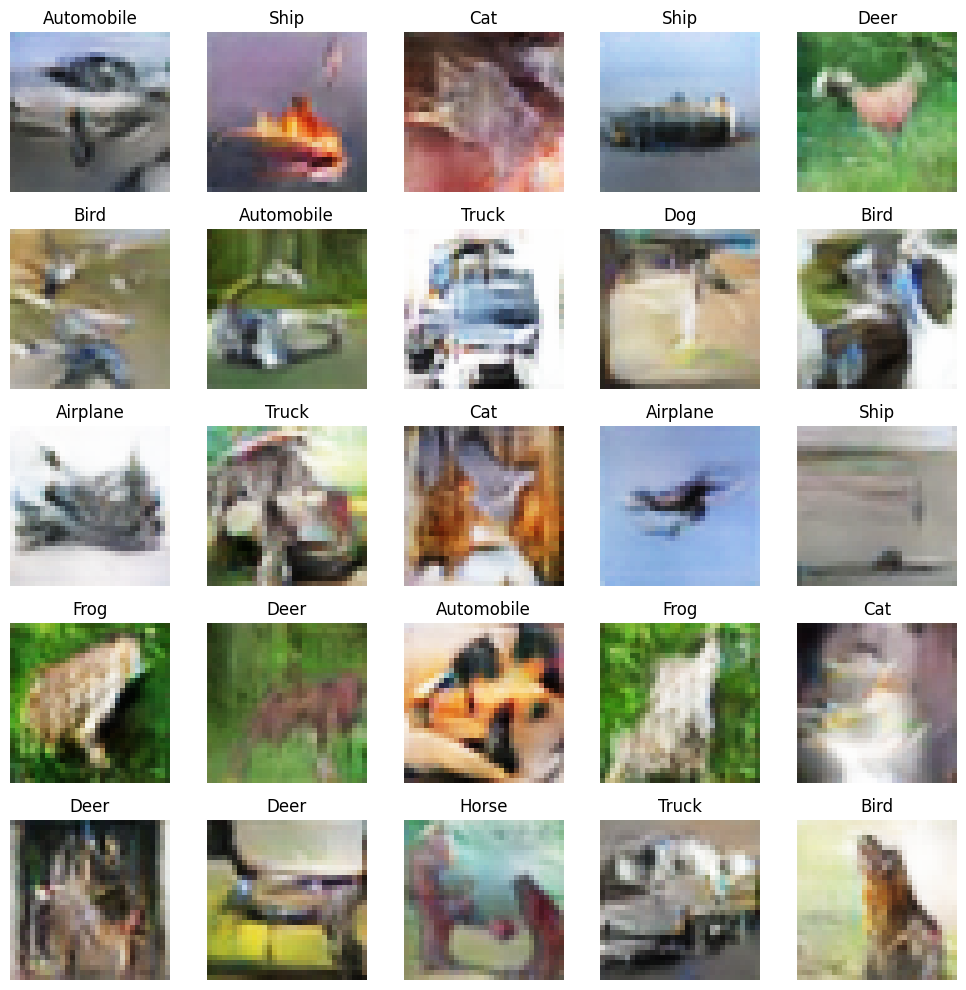

In [31]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

### Evaluation using Fréchet Inception Distance (FID)

In [13]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import math
from tqdm import tqdm
from tensorflow.image import resize
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [15]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [16]:
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
#concat x_train and x_val
full_train = np.concatenate((x_train, x_val), axis=0)
fid_class.fit(generator=cond_gan.generator, train_data=full_train)
fid_score = fid_class.evaluate()


Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 5s 124ms/step


  5%|▌         | 1/20 [00:11<03:44, 11.84s/it]

16/16 [==============================] - 2s 126ms/step


 10%|█         | 2/20 [00:16<02:15,  7.51s/it]

16/16 [==============================] - 2s 123ms/step


 15%|█▌        | 3/20 [00:20<01:41,  6.00s/it]

16/16 [==============================] - 2s 125ms/step


 20%|██        | 4/20 [00:25<01:28,  5.56s/it]

16/16 [==============================] - 2s 134ms/step


 25%|██▌       | 5/20 [00:31<01:23,  5.60s/it]

16/16 [==============================] - 4s 235ms/step


 30%|███       | 6/20 [00:40<01:38,  7.02s/it]

16/16 [==============================] - 5s 260ms/step


 35%|███▌      | 7/20 [00:55<02:03,  9.49s/it]

16/16 [==============================] - 2s 124ms/step


 40%|████      | 8/20 [00:59<01:34,  7.85s/it]

16/16 [==============================] - 2s 121ms/step


 45%|████▌     | 9/20 [01:03<01:13,  6.71s/it]

16/16 [==============================] - 2s 117ms/step


 50%|█████     | 10/20 [01:07<00:57,  5.75s/it]

16/16 [==============================] - 2s 125ms/step


 55%|█████▌    | 11/20 [01:12<00:48,  5.41s/it]

16/16 [==============================] - 2s 118ms/step


 60%|██████    | 12/20 [01:15<00:38,  4.78s/it]

16/16 [==============================] - 2s 116ms/step


 65%|██████▌   | 13/20 [01:18<00:30,  4.31s/it]

16/16 [==============================] - 2s 117ms/step


 70%|███████   | 14/20 [01:22<00:23,  4.00s/it]

16/16 [==============================] - 2s 117ms/step


 75%|███████▌  | 15/20 [01:25<00:18,  3.77s/it]

16/16 [==============================] - 2s 117ms/step


 80%|████████  | 16/20 [01:28<00:14,  3.52s/it]

16/16 [==============================] - 2s 116ms/step


 85%|████████▌ | 17/20 [01:31<00:10,  3.44s/it]

16/16 [==============================] - 2s 117ms/step


 90%|█████████ | 18/20 [01:34<00:06,  3.30s/it]

16/16 [==============================] - 2s 117ms/step


 95%|█████████▌| 19/20 [01:37<00:03,  3.33s/it]

16/16 [==============================] - 2s 119ms/step


100%|██████████| 20/20 [01:40<00:00,  5.05s/it]


Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 2s 124ms/step


  5%|▌         | 1/20 [00:03<01:15,  3.98s/it]

16/16 [==============================] - 2s 117ms/step


 10%|█         | 2/20 [00:06<01:00,  3.38s/it]

16/16 [==============================] - 2s 116ms/step


 15%|█▌        | 3/20 [00:10<00:55,  3.25s/it]

16/16 [==============================] - 2s 117ms/step


 20%|██        | 4/20 [00:13<00:50,  3.14s/it]

16/16 [==============================] - 2s 118ms/step


 25%|██▌       | 5/20 [00:15<00:46,  3.08s/it]

16/16 [==============================] - 2s 117ms/step


 30%|███       | 6/20 [00:18<00:42,  3.02s/it]

16/16 [==============================] - 2s 117ms/step


 35%|███▌      | 7/20 [00:21<00:39,  3.04s/it]

16/16 [==============================] - 2s 117ms/step


 40%|████      | 8/20 [00:24<00:36,  3.04s/it]

16/16 [==============================] - 2s 119ms/step


 45%|████▌     | 9/20 [00:28<00:33,  3.05s/it]

16/16 [==============================] - 2s 117ms/step


 50%|█████     | 10/20 [00:31<00:30,  3.10s/it]

16/16 [==============================] - 2s 121ms/step


 55%|█████▌    | 11/20 [00:35<00:29,  3.30s/it]

16/16 [==============================] - 2s 121ms/step


 60%|██████    | 12/20 [00:38<00:25,  3.22s/it]

16/16 [==============================] - 2s 121ms/step


 65%|██████▌   | 13/20 [00:41<00:22,  3.17s/it]

16/16 [==============================] - 2s 120ms/step


 70%|███████   | 14/20 [00:44<00:18,  3.15s/it]

16/16 [==============================] - 2s 121ms/step


 75%|███████▌  | 15/20 [00:47<00:15,  3.14s/it]

16/16 [==============================] - 2s 120ms/step


 80%|████████  | 16/20 [00:50<00:12,  3.13s/it]

16/16 [==============================] - 2s 121ms/step


 85%|████████▌ | 17/20 [00:53<00:09,  3.12s/it]

16/16 [==============================] - 2s 121ms/step


 90%|█████████ | 18/20 [00:56<00:06,  3.10s/it]

16/16 [==============================] - 2s 120ms/step


 95%|█████████▌| 19/20 [00:59<00:03,  3.11s/it]

16/16 [==============================] - 2s 124ms/step


100%|██████████| 20/20 [01:03<00:00,  3.16s/it]

Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape


The computed FID score is: 581.6139732837174


## Training the model with data augmentation

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [17]:
#initialise data augmentation
def set_up_data_aug(aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

train_aug_ds, val_ds = set_up_data_aug()
train_ds, val_ds = set_up_data_aug(lambda x : x) # apply no data aug
image_batch, label_batch = next(iter(train_aug_ds))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


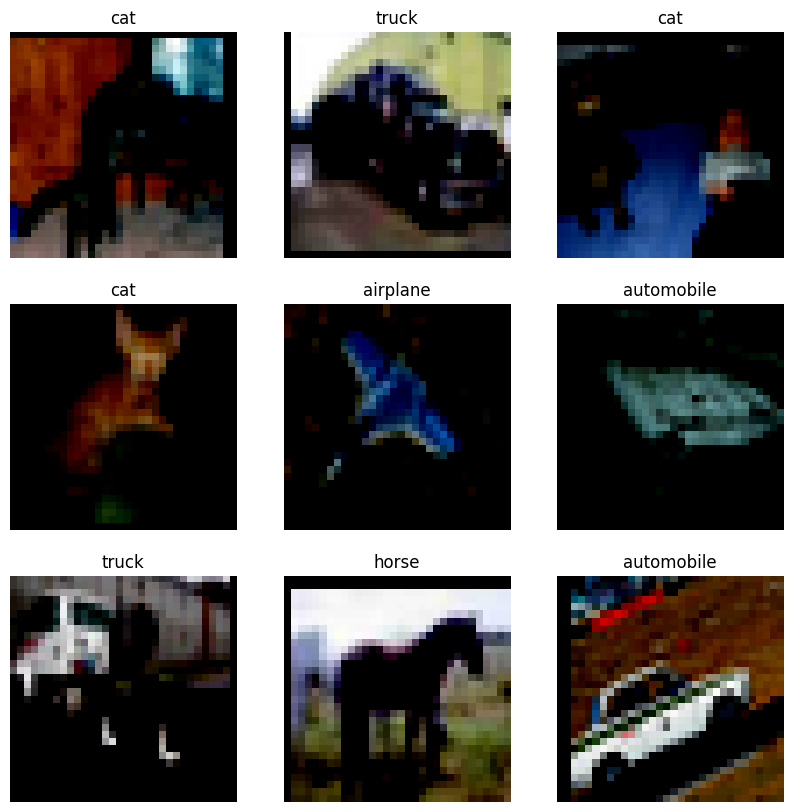

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]))
    plt.axis("off")

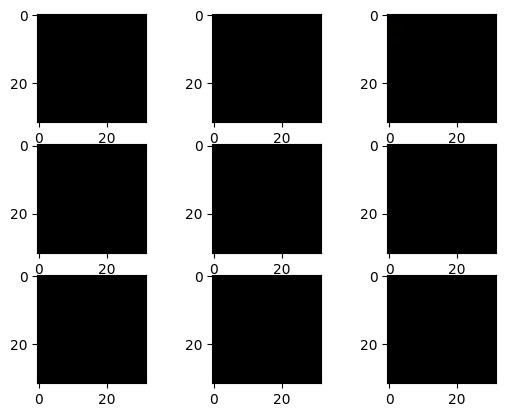

In [20]:
# set up image augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
from keras.optimizers import SGD, Adam
#@title Base Hyperparameters
LR = 0.05 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
WEIGHT_DECAY = 0.0005 #@param {type:"number"}
MAX_EPOCHS = 200 #@param {type:"integer"}
VAL_SPLIT = 0.2
base_hparams = {
    "val_split" : VAL_SPLIT,
    "max_epochs" : MAX_EPOCHS,
    "batch_size" : BATCH_SIZE
}
from math import ceil
steps_per_epoch = ceil(len(x_train)/ BATCH_SIZE)
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)


ValueError: Dimensions 40128 and 40000 are not compatible

# Trying out DCGAN
>DCGAN is a Deep Convolutional Generative Adversarial network that uses Deep Conv Nets to have a stable architecture and better results. The Generator in GAN uses a fully connected network, whereas DCGAN uses a Transposed Convolutional network to upsample the images.

## Discriminator built

In [30]:
from keras.initializers import RandomNormal 
from tensorflow_addons.layers import SpectralNormalization
def make_discriminator_model():
    discriminator = Sequential([
        Input(shape=(32,32,3)),

        ## 2 by 2 Strides for downsampling
        ## Leaky ReLU for Activation
        SpectralNormalization(
            Conv2D(64, kernel_size=4, strides=2, padding='same')
        ),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        
        # Conv 2
        SpectralNormalization(
            Conv2D(128, kernel_size=4, strides=2, padding='same')
        ),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),

        # Conv 3
        SpectralNormalization(
            Conv2D(256, kernel_size=4, strides=2, padding='same')
        ),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        
        # # Conv 4
        SpectralNormalization(
            Conv2D(512, kernel_size=4, strides=2, padding='same')
        ),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),

        GlobalMaxPooling2D(),
        Dense(1, activation='sigmoid'),
    ], name='discriminator_GAN')
    return discriminator

## Generator Built

In [18]:
def make_generator_model(latent_dim):
# gaussian weights initialization
    generator = Sequential([
        # fc block: handling latent vector z
        Input(shape=(latent_dim,)),
        Dense(2*2*512),
        Reshape((2, 2, 512)),

        # Conv 1
        ## using a kernel size that is a factor of the stride
        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Conv 2
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Conv 3
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Output Layer
        Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')
    ], name='generator_GAN')
    return generator

In [19]:
# Hyperparameters and Constants
BATCH_SIZE  = 64
LATENT_DIM  = 128
AUTO        = tf.data.AUTOTUNE
EPOCHS      = 100
BUFFER_SIZE = 1024
INPUT_DIM   = (32, 32, 3)

## DCGAN Built

In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data
        
        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator([combined_images, combined_condition])
            d_loss = self.loss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])        
            g_loss = self.loss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

## Creating a call-back function

In [ ]:
# Custom callback to monitor the Generator at every n epoch
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=10, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.constant_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator(self.constant_latent_vector)

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/dcgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

dcgan = DCGAN(
    discriminator=make_discriminator_model(), 
    generator=make_generator_model(LATENT_DIM), 
    latent_dim=LATENT_DIM
)

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Training the model

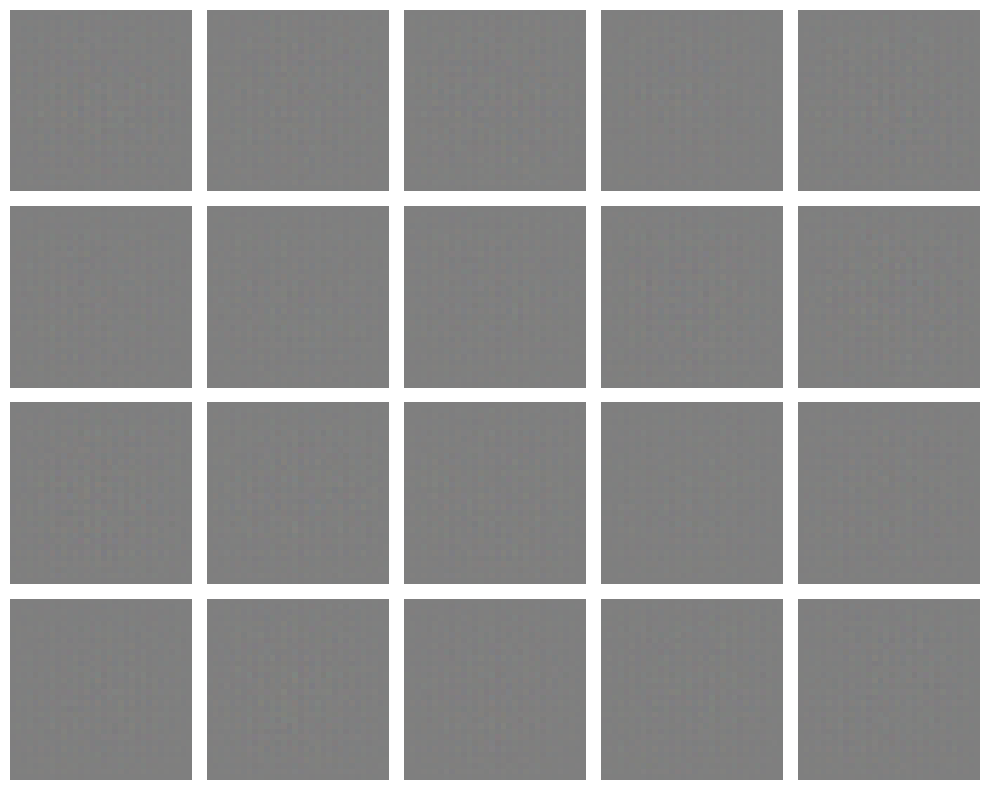

Generator Checkpoint - ./model/dcgan/generator-epoch-0.h5
Epoch 1/100


OperatorNotAllowedInGraphError: in user code:

    File "c:\Users\Xavier\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Xavier\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Xavier\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Xavier\AppData\Local\Temp\ipykernel_25608\3962663426.py", line 22, in train_step
        real_images, condition = data

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE, num_parallel_calls=AUTO).prefetch(AUTO)

# Starting the Train Process
hist = dcgan.fit(dataset, epochs=EPOCHS, use_multiprocessing=True, workers=16, callbacks=callbacks)

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

NameError: name 'hist' is not defined

In [ ]:
# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    for cols in [["d_loss", "g_loss"], ["D(x|y)", "D(G(z|y))"], "KL Divergence"]:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
        hist_df.loc[:, cols].plot(ax=ax)
        plt.show()

In [ ]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

## Evaluation using Fréchet Inception Distance (FID)


# Trying out ACGAN
<h2> Auxiliary Classifier Generative Adversarial Network, or ACGAN in short, follows a similar architecture to a Conditional GAN. </h2>

>There are two main difference between the CGAN and ACGAN - the discriminator produces two outputs and an auxiliary loss function is included in the training process.

## Generator Built

In [7]:
# latent noise vector z
z = Input(shape=(128,), name="Latent_Noise_Vector_z")

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

# Generator network
merged_layer = Concatenate()([z, conditions])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

base_generator = Sequential([
    # Conv 1: 4x4x256
    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 2: 8x8x128
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 3: 16x16x64
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Generator')
generator = base_generator(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', name='Output_Layer')(generator)

generator = Model(inputs=[z, conditions], outputs=generator, name='generator')

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

In [ ]:
# visualise model
plot_model(generator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Discriminator Built

In [8]:
# input image
img_input = Input(shape=(x_train[0].shape), name='Image_Input')

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

base_discriminator = Sequential([
    # 16x16x64
    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 8x8x128
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 4x4x256
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 2x2x512
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Discriminator')
discriminator = base_discriminator(img_input)

# Feature Extraction via GAP: 512
discriminator = GlobalAveragePooling2D()(discriminator)

# Concatenate - combine with conditions y
merged_layer = Concatenate()([discriminator, conditions])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
Disc_Output_Layer = Dense(1, activation='sigmoid', name='Disc_Output_Layer')(discriminator)
Aux_Output_Layer = Dense(10, activation='softmax', name='Aux_Output_Layer')(discriminator)

discriminator = Model(inputs=[img_input, conditions], outputs=[Disc_Output_Layer, Aux_Output_Layer], name='discriminator')

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Base_Discriminator (Sequential  (None, 2, 2, 512)   2760384     ['Image_Input[0][0]']            
 )                                                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['Base_Discriminator[0][0]']     
 alAveragePooling2D)                                                                              
                                                                                      

In [ ]:

# visualise model
plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Combining Generator and Discriminator

In [9]:
import keras
latent_dim = 128
channels = 3
nclasses = 10
img_shape = (32, 32, 3)
discriminator_in_channels = 10 + 3
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, disc_loss_fn, aux_loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.disc_loss_fn = disc_loss_fn
        self.aux_loss_fn = aux_loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            disc_output, aux_output = self.discriminator([combined_images, combined_condition])
            disc_d_loss = self.disc_loss_fn(labels, disc_output)
            aux_d_loss = self.aux_loss_fn(combined_condition, aux_output)
            d_loss = disc_d_loss + aux_d_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(disc_output)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        # Train the Generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            disc_output, aux_output = self.discriminator([fake_images, condition])        
            disc_g_loss = self.disc_loss_fn(misleading_labels, disc_output)
            aux_g_loss = self.aux_loss_fn(condition, aux_output)
            g_loss = disc_g_loss + aux_g_loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(disc_output)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }
# Custom callback to display generated images every n epochs and after training
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=20, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax

        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(classes[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/acgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

In [10]:
aux_cond_gan = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
aux_cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    disc_loss_fn=keras.losses.BinaryCrossentropy(),
    aux_loss_fn=keras.losses.CategoricalCrossentropy()
)

## Training the model

1/1 [==============================] - 0s 256ms/step


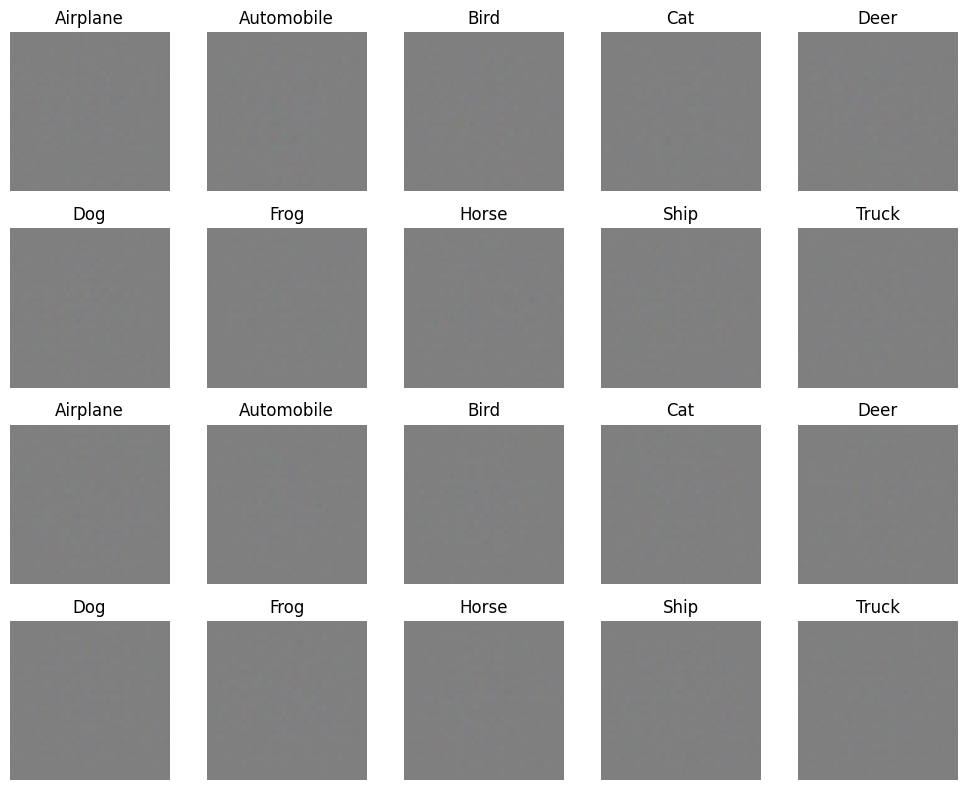

Generator Checkpoint - ./model/acgan/generator-epoch-0.h5
Epoch 1/100
625/625 [==============================] - 36s 48ms/step - d_loss: 1.7391 - g_loss: 4.3797 - D(x|y): 0.5417 - D(G(z|y)): 0.1327 - KL Divergence: 5.9080
Epoch 2/100
625/625 [==============================] - 30s 47ms/step - d_loss: 0.3494 - g_loss: 4.0243 - D(x|y): 0.4959 - D(G(z|y)): 0.0439 - KL Divergence: 5.9455
Epoch 3/100
625/625 [==============================] - 31s 49ms/step - d_loss: 0.2734 - g_loss: 3.8469 - D(x|y): 0.4989 - D(G(z|y)): 0.0496 - KL Divergence: 5.7881
Epoch 4/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2613 - g_loss: 3.6365 - D(x|y): 0.4986 - D(G(z|y)): 0.0572 - KL Divergence: 5.0934
Epoch 5/100
1/1 [==============================] - 0s 36ms/step


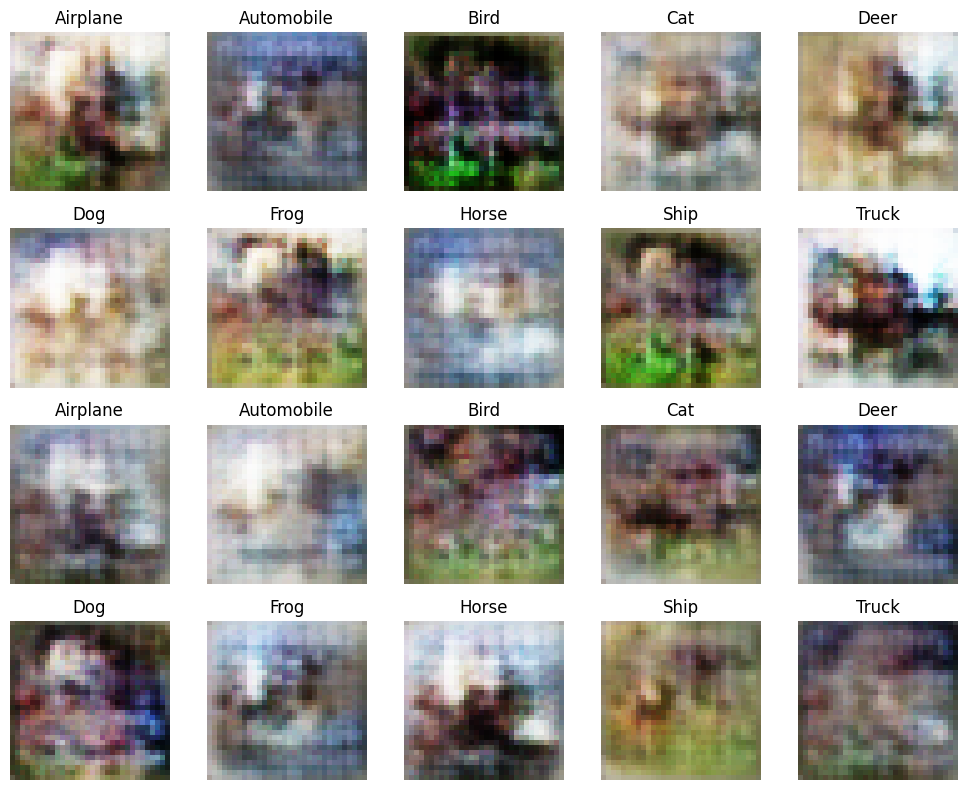

Generator Checkpoint - ./model/acgan/generator-epoch-5.h5
Epoch 6/100
625/625 [==============================] - 31s 50ms/step - d_loss: 0.2438 - g_loss: 3.6989 - D(x|y): 0.4994 - D(G(z|y)): 0.0574 - KL Divergence: 5.2597
Epoch 7/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2281 - g_loss: 3.6327 - D(x|y): 0.5000 - D(G(z|y)): 0.0644 - KL Divergence: 5.1487
Epoch 8/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.2403 - g_loss: 3.4441 - D(x|y): 0.4992 - D(G(z|y)): 0.0777 - KL Divergence: 5.1857
Epoch 9/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2413 - g_loss: 3.3653 - D(x|y): 0.5000 - D(G(z|y)): 0.0839 - KL Divergence: 5.0458
Epoch 10/100
1/1 [==============================] - 0s 32ms/step


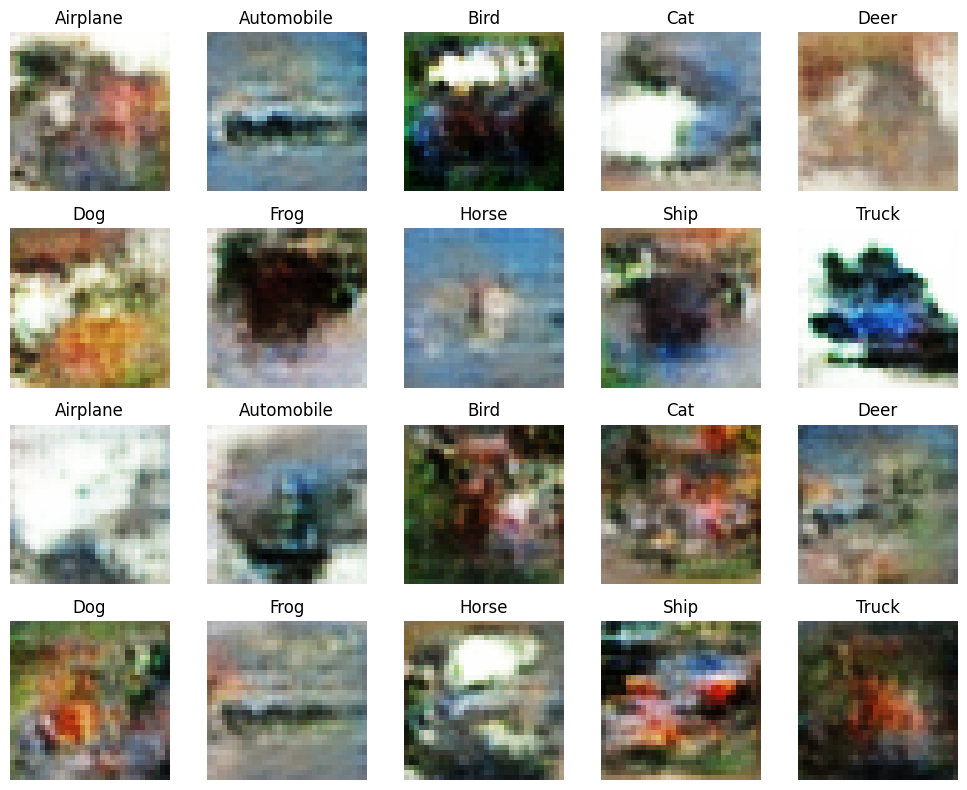

Generator Checkpoint - ./model/acgan/generator-epoch-10.h5
Epoch 11/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2569 - g_loss: 3.2046 - D(x|y): 0.5001 - D(G(z|y)): 0.1031 - KL Divergence: 4.7024
Epoch 12/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.2423 - g_loss: 3.1748 - D(x|y): 0.5006 - D(G(z|y)): 0.1035 - KL Divergence: 4.6705
Epoch 13/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2531 - g_loss: 3.1215 - D(x|y): 0.4999 - D(G(z|y)): 0.1078 - KL Divergence: 4.6708
Epoch 14/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.2419 - g_loss: 3.1938 - D(x|y): 0.5002 - D(G(z|y)): 0.1059 - KL Divergence: 4.5964
Epoch 15/100
1/1 [==============================] - 0s 25ms/step


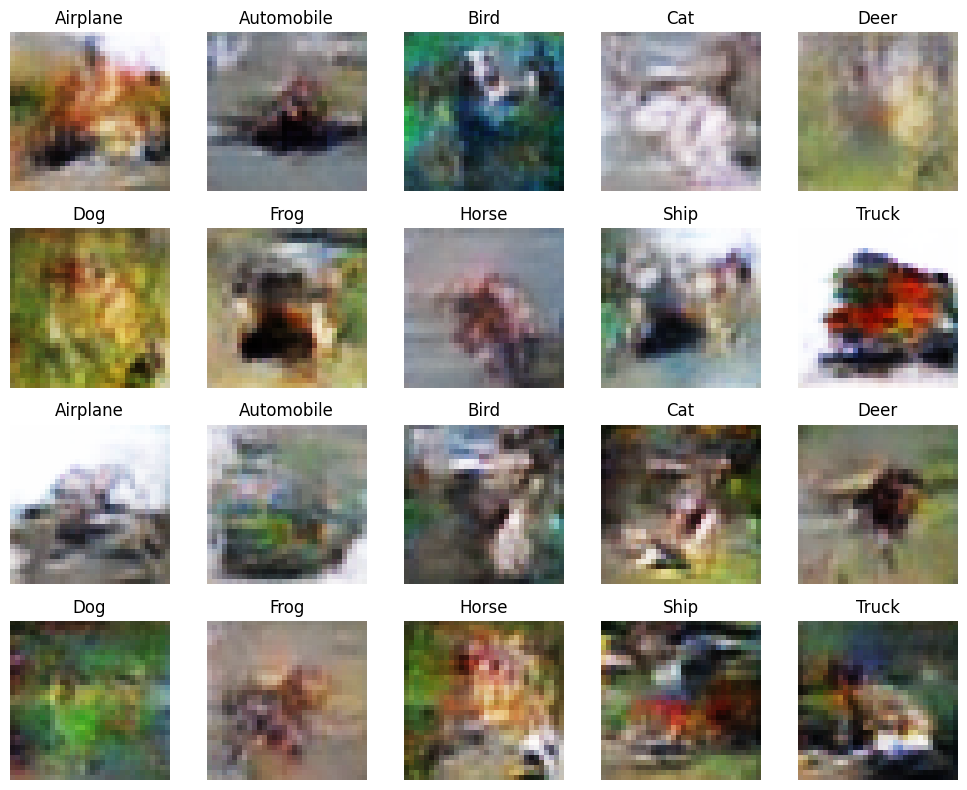

Generator Checkpoint - ./model/acgan/generator-epoch-15.h5
Epoch 16/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.2480 - g_loss: 3.0375 - D(x|y): 0.4999 - D(G(z|y)): 0.1184 - KL Divergence: 4.6025
Epoch 17/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.2364 - g_loss: 3.1510 - D(x|y): 0.5007 - D(G(z|y)): 0.1116 - KL Divergence: 4.5549
Epoch 18/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.2285 - g_loss: 3.1948 - D(x|y): 0.4999 - D(G(z|y)): 0.1120 - KL Divergence: 4.5906
Epoch 19/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2403 - g_loss: 3.1118 - D(x|y): 0.5005 - D(G(z|y)): 0.1229 - KL Divergence: 4.6189
Epoch 20/100
1/1 [==============================] - 0s 32ms/step


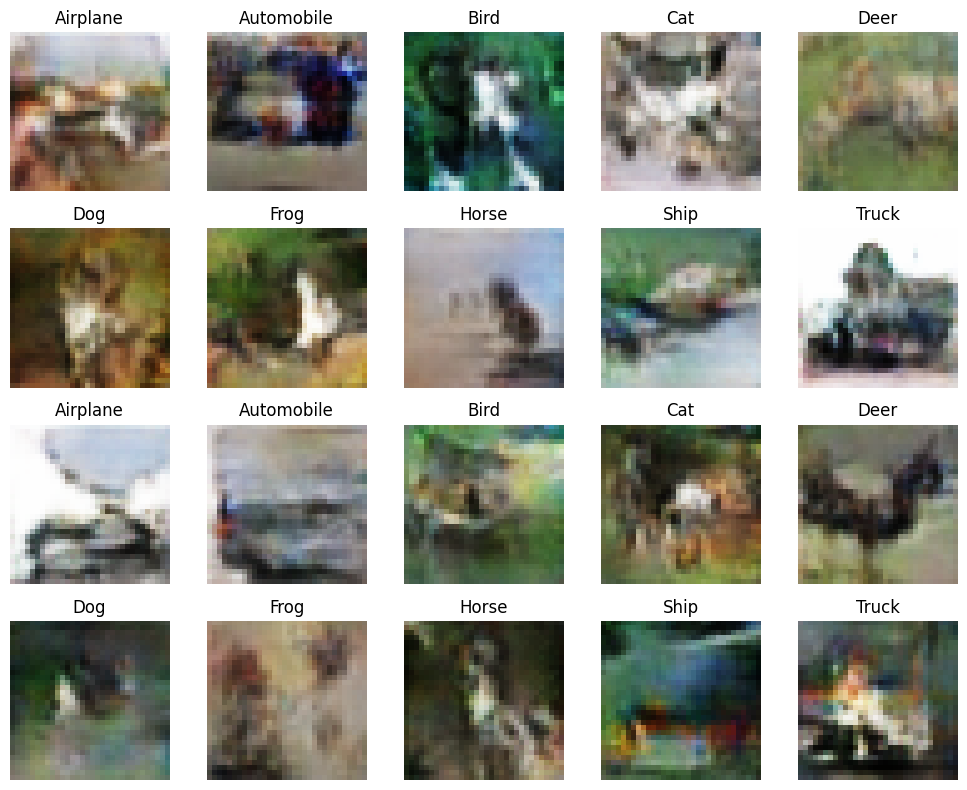

Generator Checkpoint - ./model/acgan/generator-epoch-20.h5
Epoch 21/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.2254 - g_loss: 3.2328 - D(x|y): 0.5007 - D(G(z|y)): 0.1174 - KL Divergence: 4.4742
Epoch 22/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2274 - g_loss: 3.2060 - D(x|y): 0.5002 - D(G(z|y)): 0.1211 - KL Divergence: 4.6328
Epoch 23/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.2253 - g_loss: 3.2338 - D(x|y): 0.5003 - D(G(z|y)): 0.1234 - KL Divergence: 4.5686
Epoch 24/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.2121 - g_loss: 3.3659 - D(x|y): 0.5000 - D(G(z|y)): 0.1150 - KL Divergence: 4.5368
Epoch 25/100
1/1 [==============================] - 0s 77ms/step


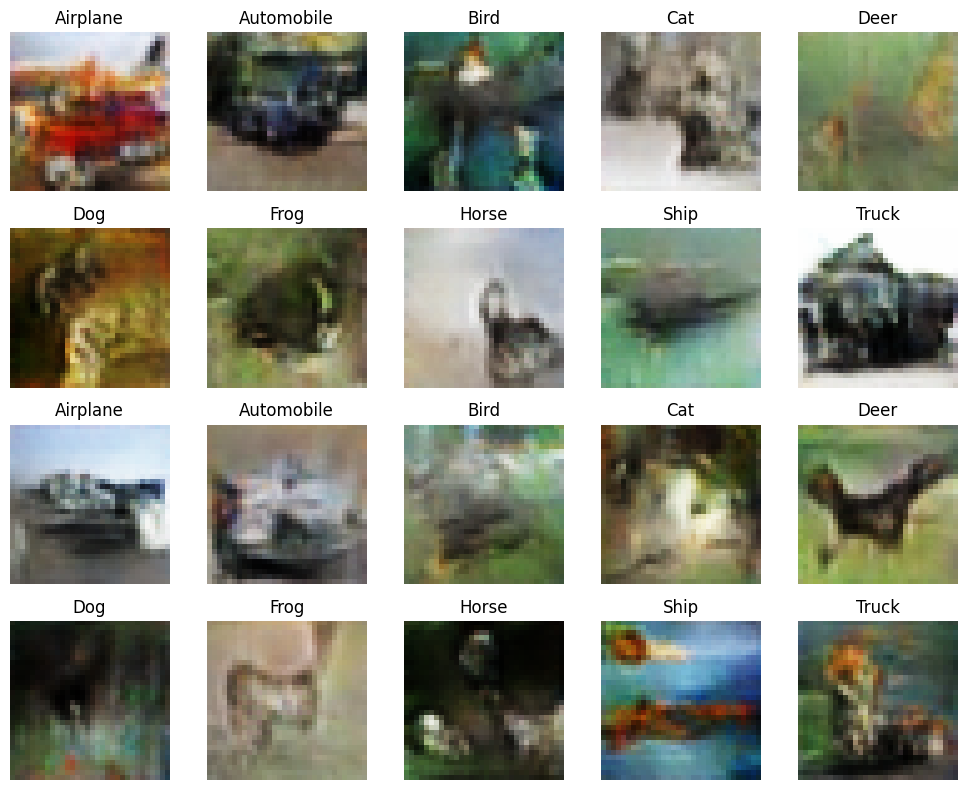

Generator Checkpoint - ./model/acgan/generator-epoch-25.h5
Epoch 26/100
625/625 [==============================] - 39s 62ms/step - d_loss: 0.2036 - g_loss: 3.6194 - D(x|y): 0.4992 - D(G(z|y)): 0.1104 - KL Divergence: 4.5978
Epoch 27/100
625/625 [==============================] - 35s 56ms/step - d_loss: 0.1845 - g_loss: 3.5900 - D(x|y): 0.4998 - D(G(z|y)): 0.1095 - KL Divergence: 4.6051
Epoch 28/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.1739 - g_loss: 3.9681 - D(x|y): 0.5002 - D(G(z|y)): 0.0979 - KL Divergence: 4.5379
Epoch 29/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.1647 - g_loss: 4.1472 - D(x|y): 0.5001 - D(G(z|y)): 0.0945 - KL Divergence: 4.4787
Epoch 30/100
1/1 [==============================] - 0s 27ms/step


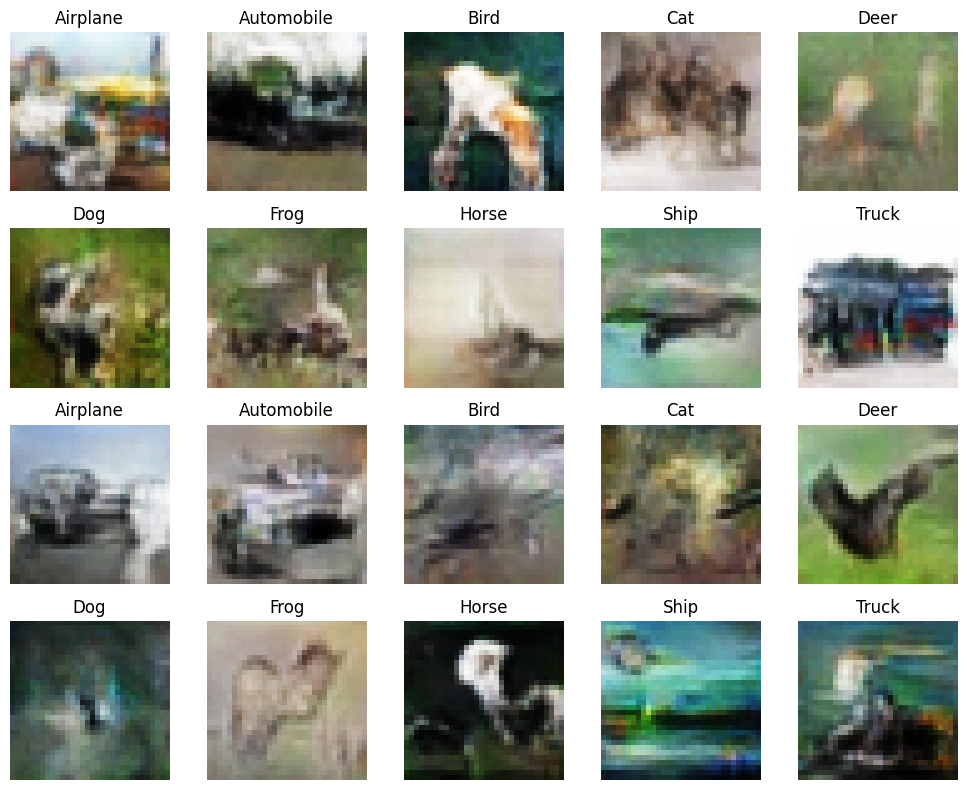

Generator Checkpoint - ./model/acgan/generator-epoch-30.h5
Epoch 31/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.1502 - g_loss: 4.4506 - D(x|y): 0.5002 - D(G(z|y)): 0.0838 - KL Divergence: 4.6107
Epoch 32/100
625/625 [==============================] - 33s 52ms/step - d_loss: 0.1459 - g_loss: 4.5844 - D(x|y): 0.5004 - D(G(z|y)): 0.0829 - KL Divergence: 4.7824
Epoch 33/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.1932 - g_loss: 4.3950 - D(x|y): 0.4994 - D(G(z|y)): 0.0996 - KL Divergence: 4.8165
Epoch 34/100
625/625 [==============================] - 32s 52ms/step - d_loss: 0.1374 - g_loss: 4.7020 - D(x|y): 0.4999 - D(G(z|y)): 0.0752 - KL Divergence: 4.6824
Epoch 35/100
1/1 [==============================] - 0s 29ms/step


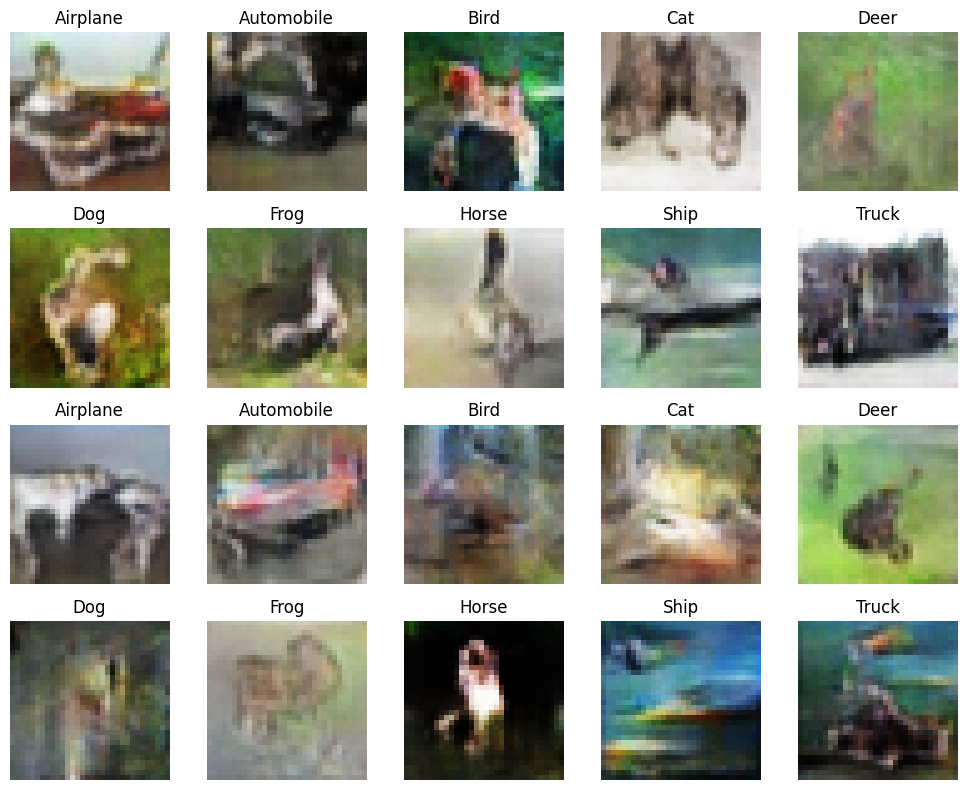

Generator Checkpoint - ./model/acgan/generator-epoch-35.h5
Epoch 36/100
625/625 [==============================] - 39s 62ms/step - d_loss: 0.1201 - g_loss: 5.1807 - D(x|y): 0.5002 - D(G(z|y)): 0.0661 - KL Divergence: 4.8408
Epoch 37/100
625/625 [==============================] - 38s 61ms/step - d_loss: 0.1210 - g_loss: 5.3176 - D(x|y): 0.4998 - D(G(z|y)): 0.0667 - KL Divergence: 4.7156
Epoch 38/100
625/625 [==============================] - 38s 61ms/step - d_loss: 0.1201 - g_loss: 5.3238 - D(x|y): 0.5003 - D(G(z|y)): 0.0656 - KL Divergence: 4.8332
Epoch 39/100
625/625 [==============================] - 38s 61ms/step - d_loss: 0.1170 - g_loss: 5.4983 - D(x|y): 0.4997 - D(G(z|y)): 0.0647 - KL Divergence: 4.8020
Epoch 40/100
1/1 [==============================] - 0s 61ms/step


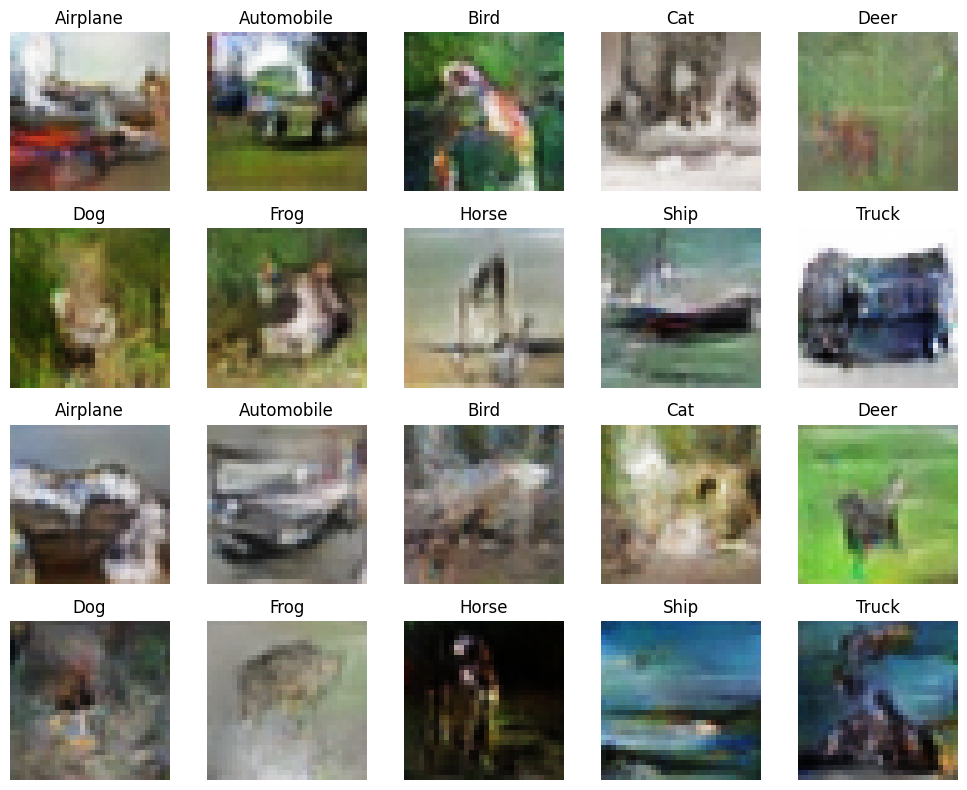

Generator Checkpoint - ./model/acgan/generator-epoch-40.h5
Epoch 41/100
625/625 [==============================] - 41s 66ms/step - d_loss: 0.1104 - g_loss: 5.7481 - D(x|y): 0.5002 - D(G(z|y)): 0.0582 - KL Divergence: 4.8736
Epoch 42/100
625/625 [==============================] - 44s 71ms/step - d_loss: 0.1104 - g_loss: 5.7995 - D(x|y): 0.4996 - D(G(z|y)): 0.0613 - KL Divergence: 4.6643
Epoch 43/100
625/625 [==============================] - 40s 64ms/step - d_loss: 0.1077 - g_loss: 5.8390 - D(x|y): 0.5002 - D(G(z|y)): 0.0597 - KL Divergence: 4.5915
Epoch 44/100
625/625 [==============================] - 40s 64ms/step - d_loss: 0.1053 - g_loss: 6.0827 - D(x|y): 0.5000 - D(G(z|y)): 0.0553 - KL Divergence: 4.6916
Epoch 45/100
1/1 [==============================] - 0s 40ms/step


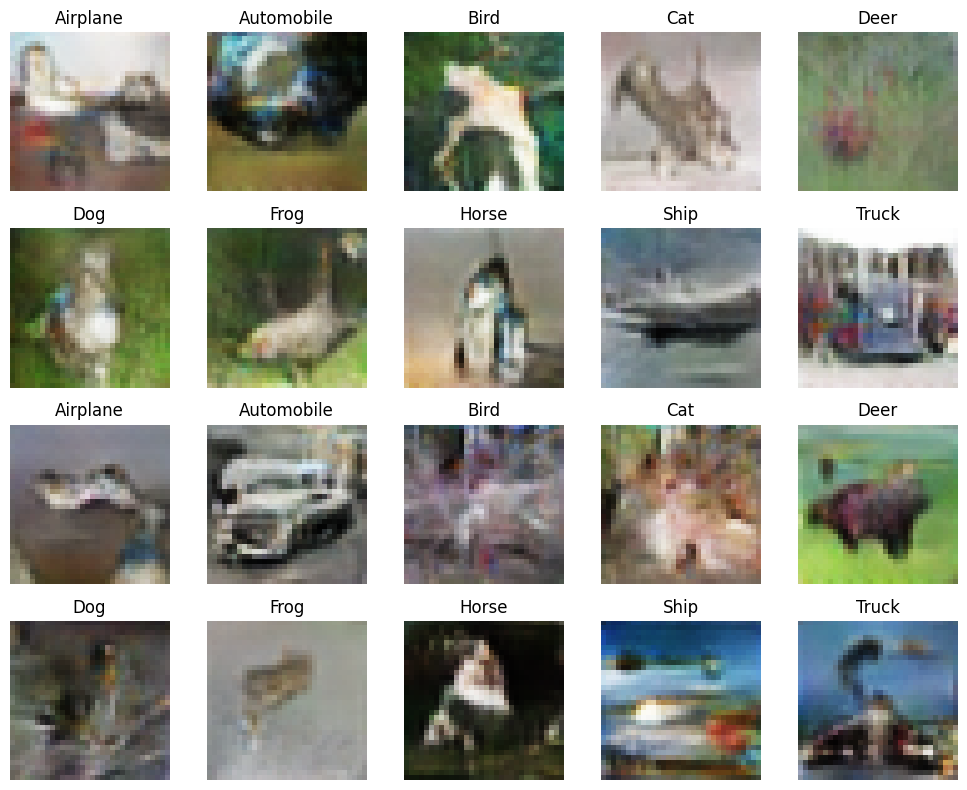

Generator Checkpoint - ./model/acgan/generator-epoch-45.h5
Epoch 46/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.1044 - g_loss: 6.0788 - D(x|y): 0.5004 - D(G(z|y)): 0.0582 - KL Divergence: 4.6368
Epoch 47/100
625/625 [==============================] - 38s 61ms/step - d_loss: 0.1037 - g_loss: 6.1582 - D(x|y): 0.5000 - D(G(z|y)): 0.0540 - KL Divergence: 4.5456
Epoch 48/100
625/625 [==============================] - 51s 81ms/step - d_loss: 0.1053 - g_loss: 6.2890 - D(x|y): 0.5005 - D(G(z|y)): 0.0548 - KL Divergence: 4.5081
Epoch 49/100
625/625 [==============================] - 38s 60ms/step - d_loss: 0.0988 - g_loss: 6.3224 - D(x|y): 0.5001 - D(G(z|y)): 0.0522 - KL Divergence: 4.7368
Epoch 50/100
1/1 [==============================] - 0s 40ms/step


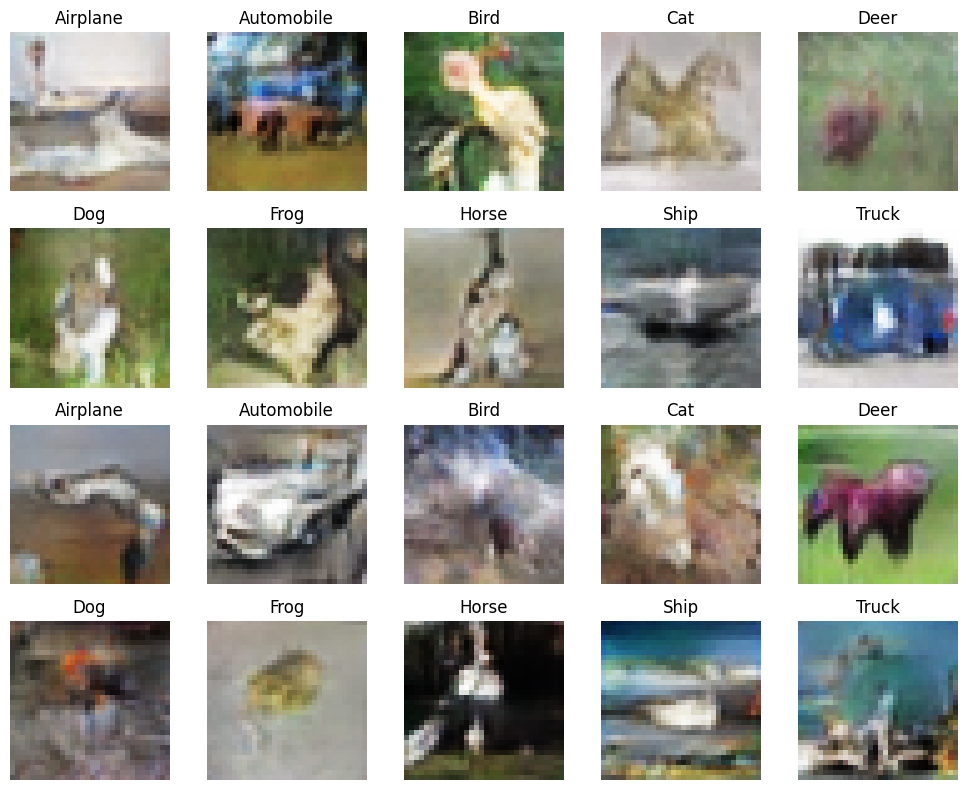

Generator Checkpoint - ./model/acgan/generator-epoch-50.h5
Epoch 51/100
625/625 [==============================] - 35s 55ms/step - d_loss: 0.1024 - g_loss: 6.4989 - D(x|y): 0.5004 - D(G(z|y)): 0.0543 - KL Divergence: 4.5905
Epoch 52/100
625/625 [==============================] - 34s 55ms/step - d_loss: 0.0967 - g_loss: 6.5132 - D(x|y): 0.5002 - D(G(z|y)): 0.0538 - KL Divergence: 4.7144
Epoch 53/100
625/625 [==============================] - 34s 55ms/step - d_loss: 0.0965 - g_loss: 6.5758 - D(x|y): 0.5002 - D(G(z|y)): 0.0486 - KL Divergence: 4.6586
Epoch 54/100
625/625 [==============================] - 37s 59ms/step - d_loss: 0.0941 - g_loss: 6.6511 - D(x|y): 0.5001 - D(G(z|y)): 0.0487 - KL Divergence: 4.6152
Epoch 55/100
1/1 [==============================] - 0s 67ms/step


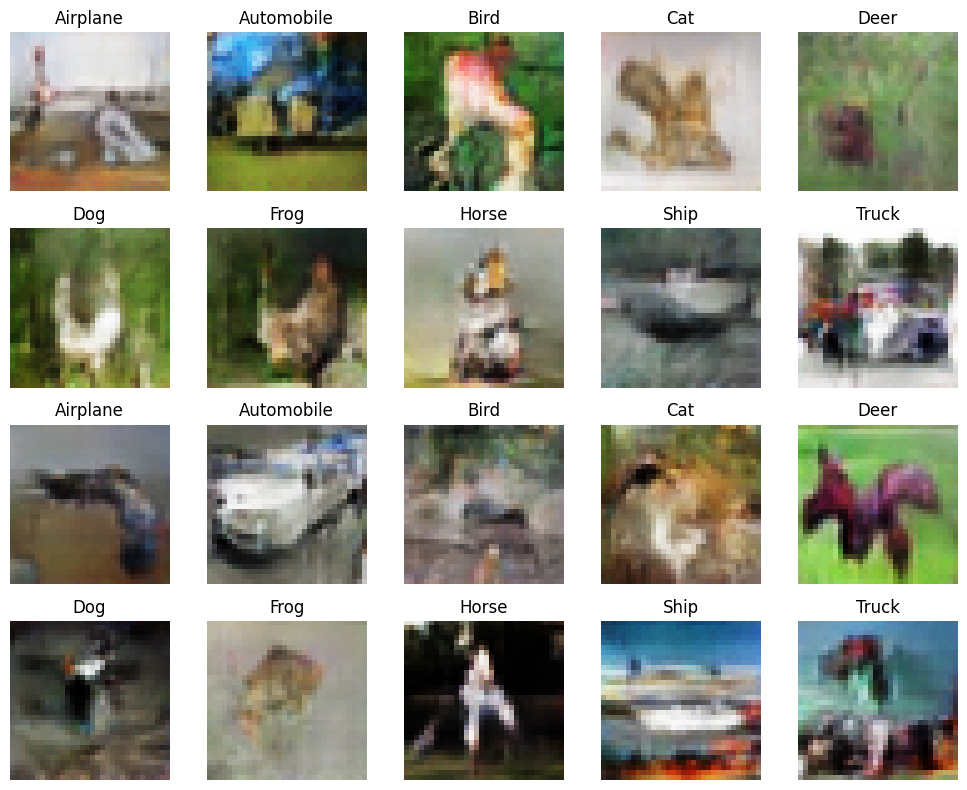

Generator Checkpoint - ./model/acgan/generator-epoch-55.h5
Epoch 56/100
625/625 [==============================] - 41s 65ms/step - d_loss: 0.0968 - g_loss: 5.9310 - D(x|y): 0.4996 - D(G(z|y)): 0.0570 - KL Divergence: 4.5847
Epoch 57/100
625/625 [==============================] - 40s 64ms/step - d_loss: 0.0816 - g_loss: 6.7179 - D(x|y): 0.4999 - D(G(z|y)): 0.0488 - KL Divergence: 4.6349
Epoch 58/100
625/625 [==============================] - 39s 62ms/step - d_loss: 0.0822 - g_loss: 7.0265 - D(x|y): 0.5000 - D(G(z|y)): 0.0433 - KL Divergence: 4.6981
Epoch 59/100
625/625 [==============================] - 35s 57ms/step - d_loss: 0.0804 - g_loss: 7.0164 - D(x|y): 0.5000 - D(G(z|y)): 0.0435 - KL Divergence: 4.7687
Epoch 60/100
1/1 [==============================] - 0s 32ms/step


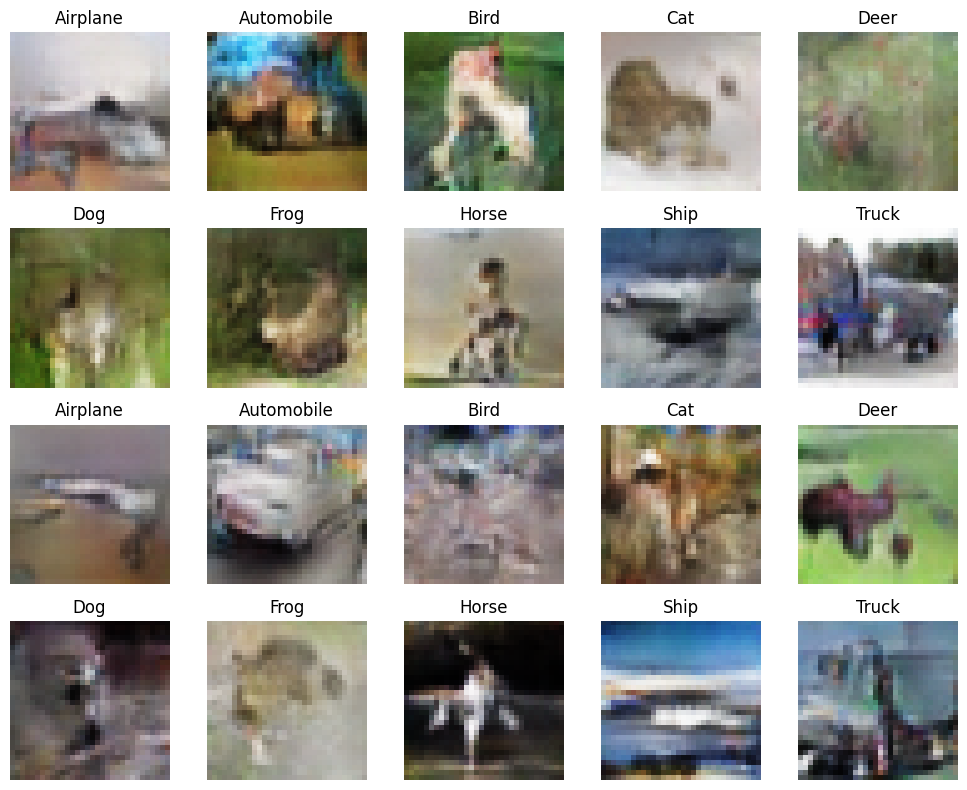

Generator Checkpoint - ./model/acgan/generator-epoch-60.h5
Epoch 61/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0829 - g_loss: 7.2897 - D(x|y): 0.5001 - D(G(z|y)): 0.0428 - KL Divergence: 4.5696
Epoch 62/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0847 - g_loss: 7.0630 - D(x|y): 0.4999 - D(G(z|y)): 0.0470 - KL Divergence: 4.6796
Epoch 63/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0812 - g_loss: 7.2082 - D(x|y): 0.4998 - D(G(z|y)): 0.0417 - KL Divergence: 4.6034
Epoch 64/100
625/625 [==============================] - 36s 57ms/step - d_loss: 0.0806 - g_loss: 7.1574 - D(x|y): 0.5006 - D(G(z|y)): 0.0435 - KL Divergence: 4.4315
Epoch 65/100
1/1 [==============================] - 0s 62ms/step


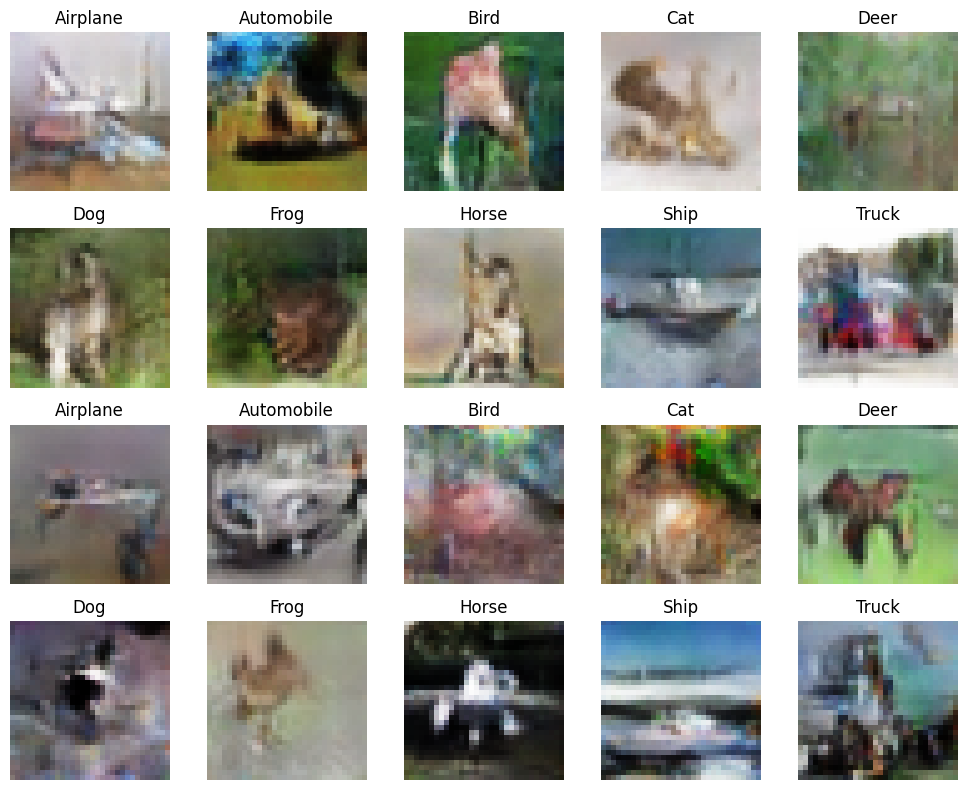

Generator Checkpoint - ./model/acgan/generator-epoch-65.h5
Epoch 66/100
625/625 [==============================] - 38s 60ms/step - d_loss: 0.0777 - g_loss: 7.5238 - D(x|y): 0.5001 - D(G(z|y)): 0.0424 - KL Divergence: 4.4655
Epoch 67/100
625/625 [==============================] - 33s 54ms/step - d_loss: 0.0775 - g_loss: 7.4807 - D(x|y): 0.5003 - D(G(z|y)): 0.0403 - KL Divergence: 4.6187
Epoch 68/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0768 - g_loss: 7.5122 - D(x|y): 0.5000 - D(G(z|y)): 0.0401 - KL Divergence: 4.5721
Epoch 69/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0830 - g_loss: 7.5794 - D(x|y): 0.5000 - D(G(z|y)): 0.0425 - KL Divergence: 4.6092
Epoch 70/100
1/1 [==============================] - 0s 31ms/step


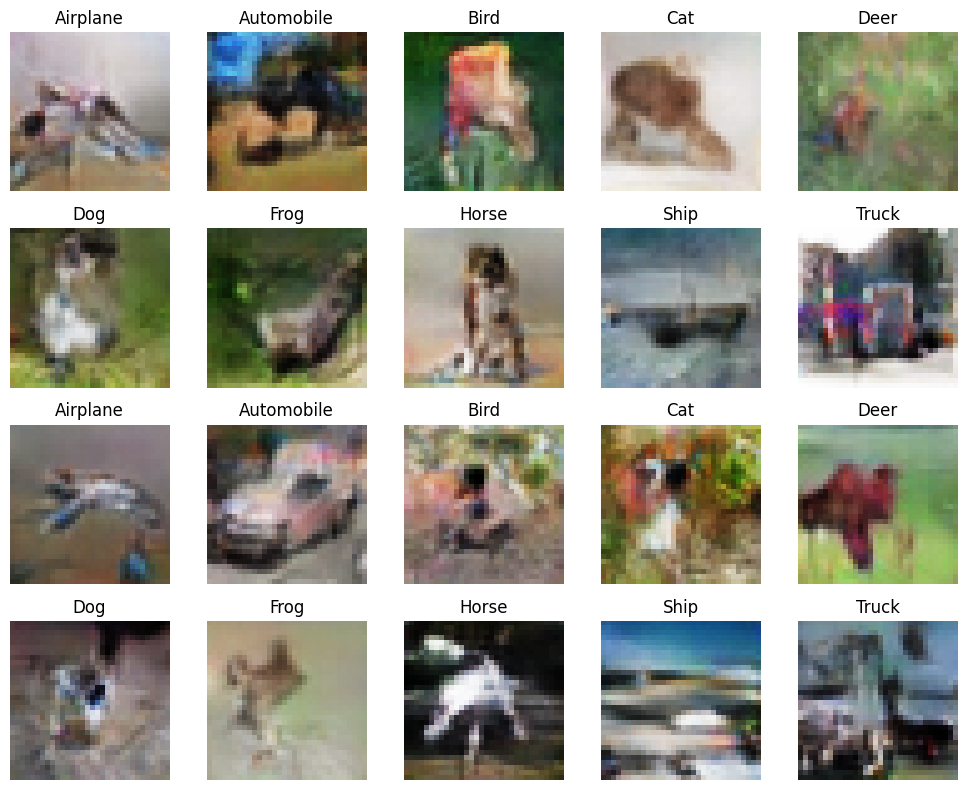

Generator Checkpoint - ./model/acgan/generator-epoch-70.h5
Epoch 71/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0751 - g_loss: 7.7245 - D(x|y): 0.5000 - D(G(z|y)): 0.0388 - KL Divergence: 4.5376
Epoch 72/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0743 - g_loss: 7.5789 - D(x|y): 0.5002 - D(G(z|y)): 0.0404 - KL Divergence: 4.5086
Epoch 73/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0730 - g_loss: 7.8348 - D(x|y): 0.5000 - D(G(z|y)): 0.0388 - KL Divergence: 4.4134
Epoch 74/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0712 - g_loss: 7.7949 - D(x|y): 0.5002 - D(G(z|y)): 0.0395 - KL Divergence: 4.5425
Epoch 75/100
1/1 [==============================] - 0s 36ms/step


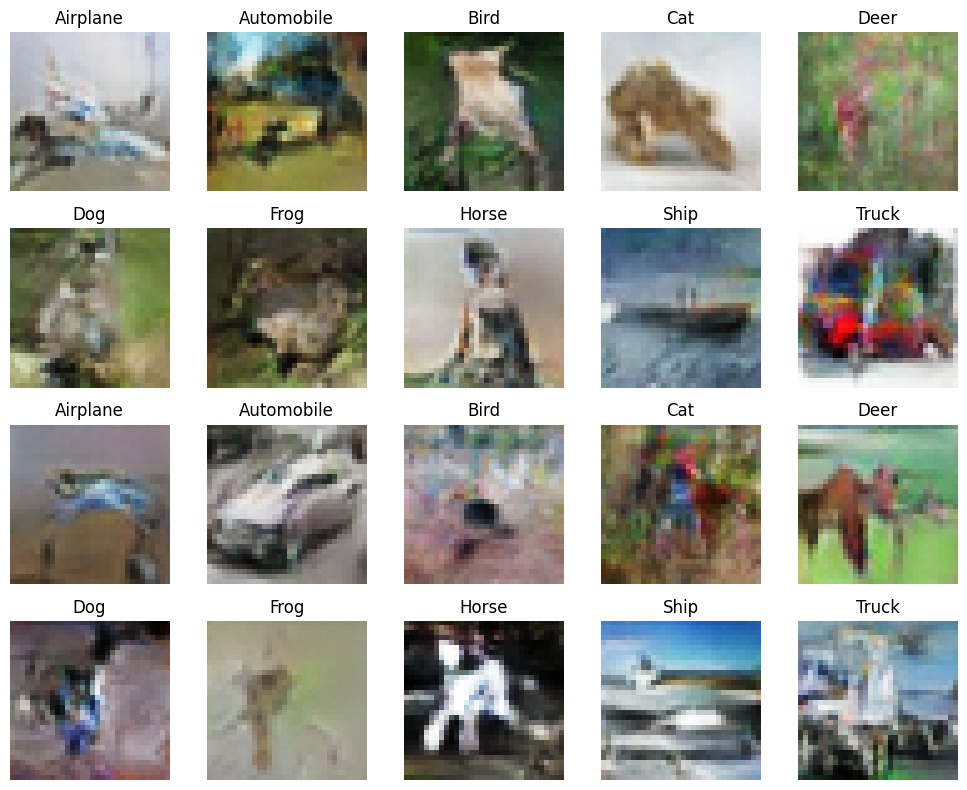

Generator Checkpoint - ./model/acgan/generator-epoch-75.h5
Epoch 76/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0688 - g_loss: 7.8201 - D(x|y): 0.5001 - D(G(z|y)): 0.0379 - KL Divergence: 4.4645
Epoch 77/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0708 - g_loss: 7.9160 - D(x|y): 0.4999 - D(G(z|y)): 0.0381 - KL Divergence: 4.5570
Epoch 78/100
625/625 [==============================] - 33s 54ms/step - d_loss: 0.0717 - g_loss: 7.8457 - D(x|y): 0.4998 - D(G(z|y)): 0.0400 - KL Divergence: 4.6188
Epoch 79/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0679 - g_loss: 7.9318 - D(x|y): 0.5003 - D(G(z|y)): 0.0368 - KL Divergence: 4.6220
Epoch 80/100
1/1 [==============================] - 0s 24ms/step


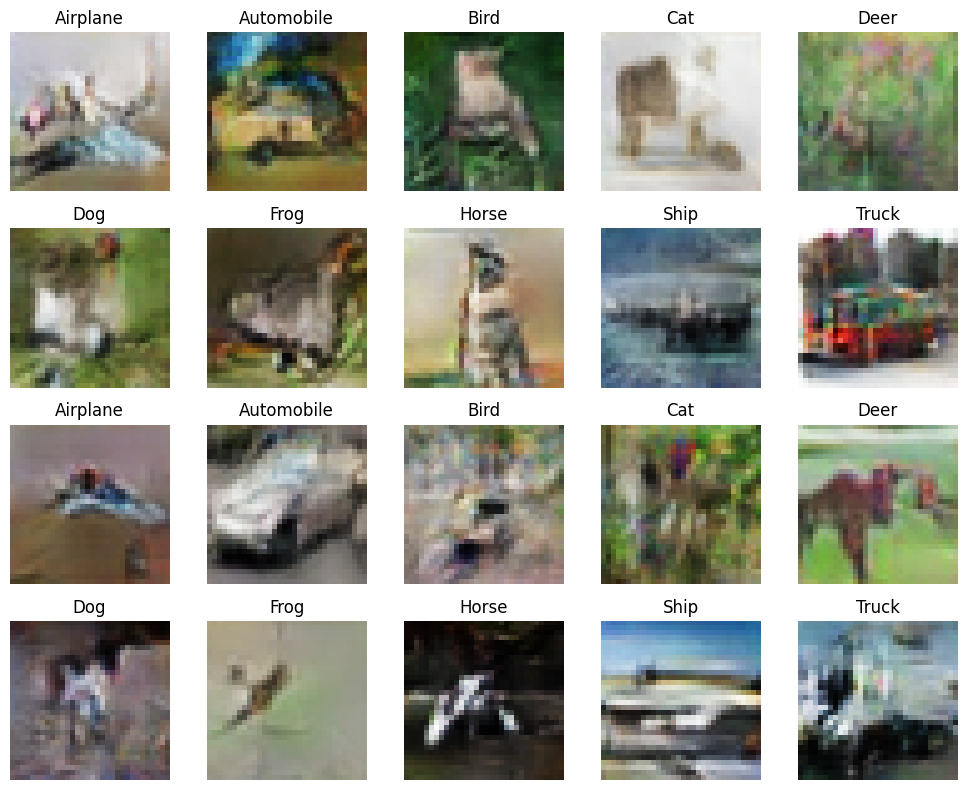

Generator Checkpoint - ./model/acgan/generator-epoch-80.h5
Epoch 81/100
625/625 [==============================] - 33s 54ms/step - d_loss: 0.0663 - g_loss: 8.2302 - D(x|y): 0.5001 - D(G(z|y)): 0.0345 - KL Divergence: 4.5633
Epoch 82/100
625/625 [==============================] - 33s 54ms/step - d_loss: 0.0646 - g_loss: 8.1652 - D(x|y): 0.5000 - D(G(z|y)): 0.0335 - KL Divergence: 4.5057
Epoch 83/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0713 - g_loss: 8.0055 - D(x|y): 0.5002 - D(G(z|y)): 0.0368 - KL Divergence: 4.5424
Epoch 84/100
625/625 [==============================] - 33s 53ms/step - d_loss: 0.0662 - g_loss: 8.3104 - D(x|y): 0.5000 - D(G(z|y)): 0.0344 - KL Divergence: 4.6915
Epoch 85/100
1/1 [==============================] - 0s 39ms/step


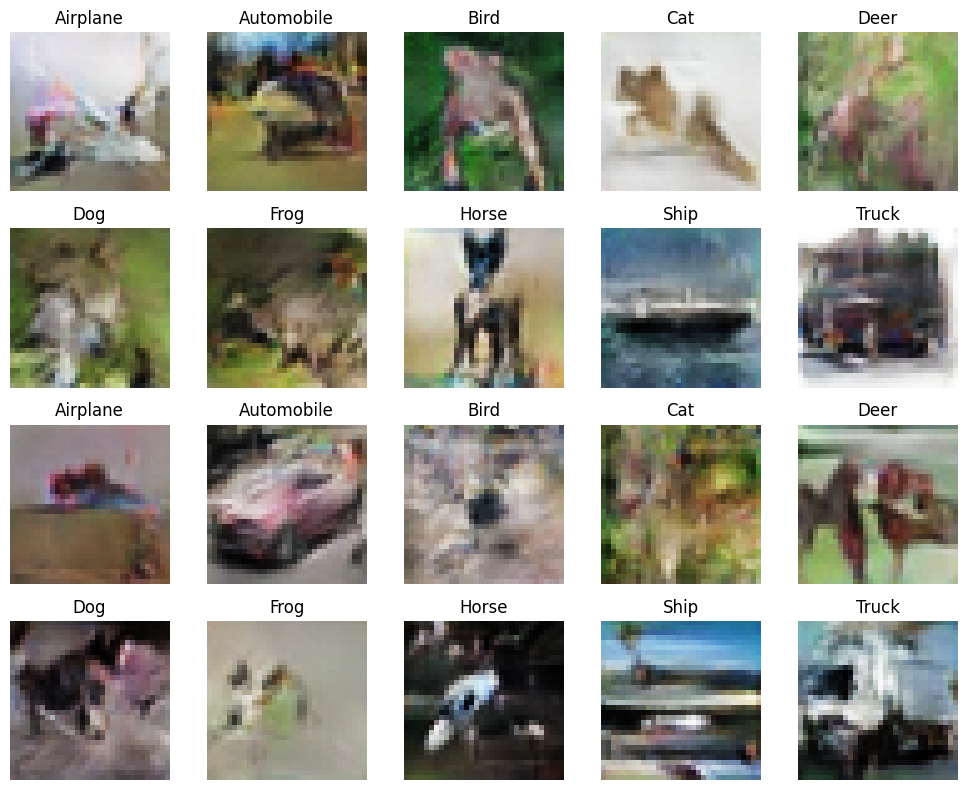

Generator Checkpoint - ./model/acgan/generator-epoch-85.h5
Epoch 86/100
625/625 [==============================] - 35s 56ms/step - d_loss: 0.0667 - g_loss: 8.1897 - D(x|y): 0.5005 - D(G(z|y)): 0.0358 - KL Divergence: 4.5742
Epoch 87/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0679 - g_loss: 8.2669 - D(x|y): 0.5003 - D(G(z|y)): 0.0354 - KL Divergence: 4.5123
Epoch 88/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0675 - g_loss: 8.5272 - D(x|y): 0.5003 - D(G(z|y)): 0.0368 - KL Divergence: 4.3821
Epoch 89/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0618 - g_loss: 8.4955 - D(x|y): 0.5001 - D(G(z|y)): 0.0323 - KL Divergence: 4.5114
Epoch 90/100
1/1 [==============================] - 0s 37ms/step


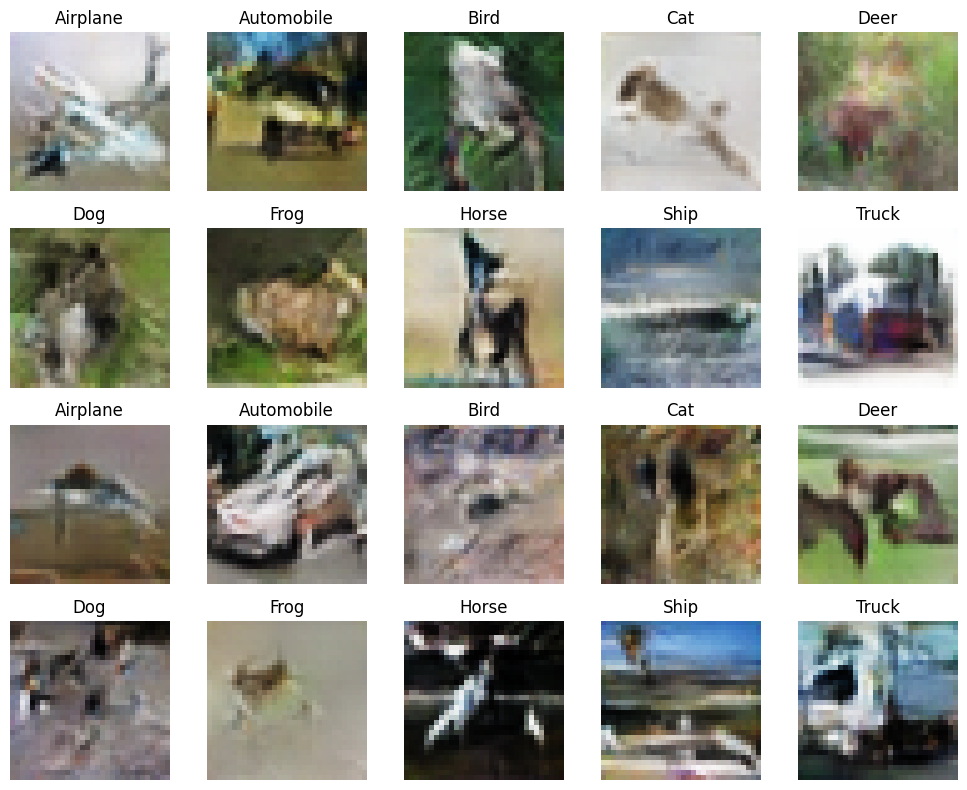

Generator Checkpoint - ./model/acgan/generator-epoch-90.h5
Epoch 91/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0635 - g_loss: 8.4962 - D(x|y): 0.5002 - D(G(z|y)): 0.0319 - KL Divergence: 4.6337
Epoch 92/100
625/625 [==============================] - 33s 54ms/step - d_loss: 0.0630 - g_loss: 8.5455 - D(x|y): 0.5001 - D(G(z|y)): 0.0323 - KL Divergence: 4.7363
Epoch 93/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0662 - g_loss: 8.5333 - D(x|y): 0.4998 - D(G(z|y)): 0.0312 - KL Divergence: 4.6368
Epoch 94/100
625/625 [==============================] - 34s 54ms/step - d_loss: 0.0568 - g_loss: 8.7083 - D(x|y): 0.5001 - D(G(z|y)): 0.0319 - KL Divergence: 4.5815
Epoch 95/100
1/1 [==============================] - 0s 39ms/step


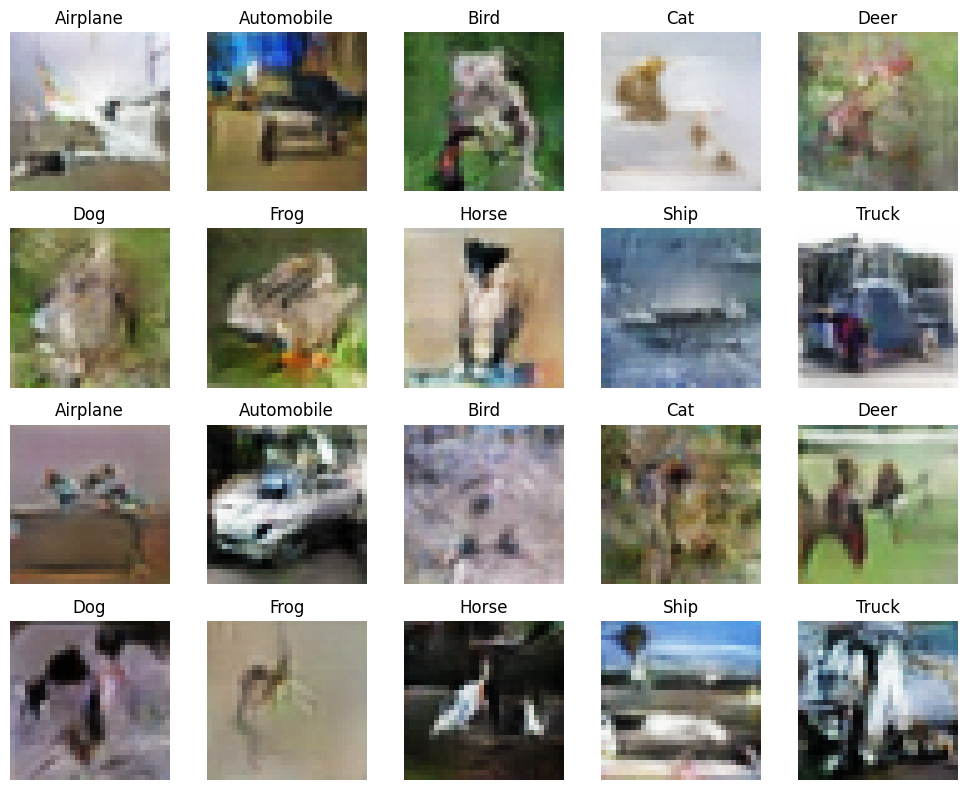

Generator Checkpoint - ./model/acgan/generator-epoch-95.h5
Epoch 96/100
625/625 [==============================] - 35s 56ms/step - d_loss: 0.0645 - g_loss: 8.7305 - D(x|y): 0.5000 - D(G(z|y)): 0.0328 - KL Divergence: 4.5702
Epoch 97/100
625/625 [==============================] - 35s 55ms/step - d_loss: 0.0598 - g_loss: 8.7323 - D(x|y): 0.5001 - D(G(z|y)): 0.0311 - KL Divergence: 4.5603
Epoch 98/100
625/625 [==============================] - 34s 55ms/step - d_loss: 0.0561 - g_loss: 8.8784 - D(x|y): 0.4997 - D(G(z|y)): 0.0314 - KL Divergence: 4.4288
Epoch 99/100
625/625 [==============================] - 34s 55ms/step - d_loss: 0.0576 - g_loss: 8.6746 - D(x|y): 0.4999 - D(G(z|y)): 0.0321 - KL Divergence: 4.4653
Epoch 100/100
1/1 [==============================] - 0s 31ms/step


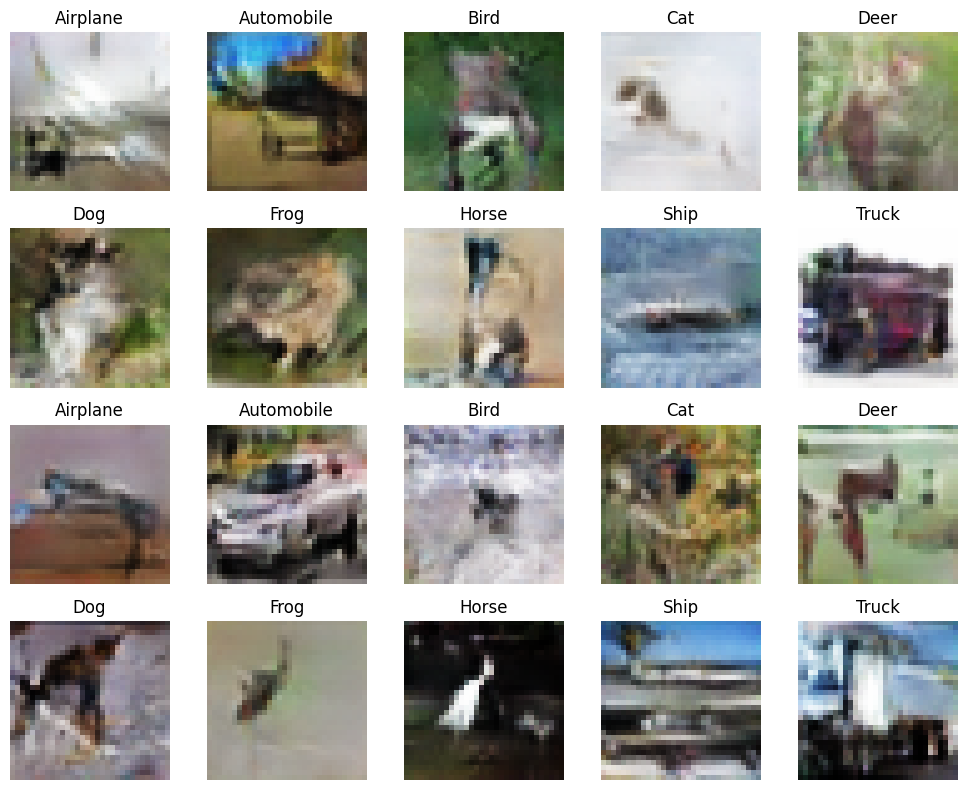

Generator Checkpoint - ./model/acgan/generator-epoch-Full Train.h5


In [ ]:

# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = aux_cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)


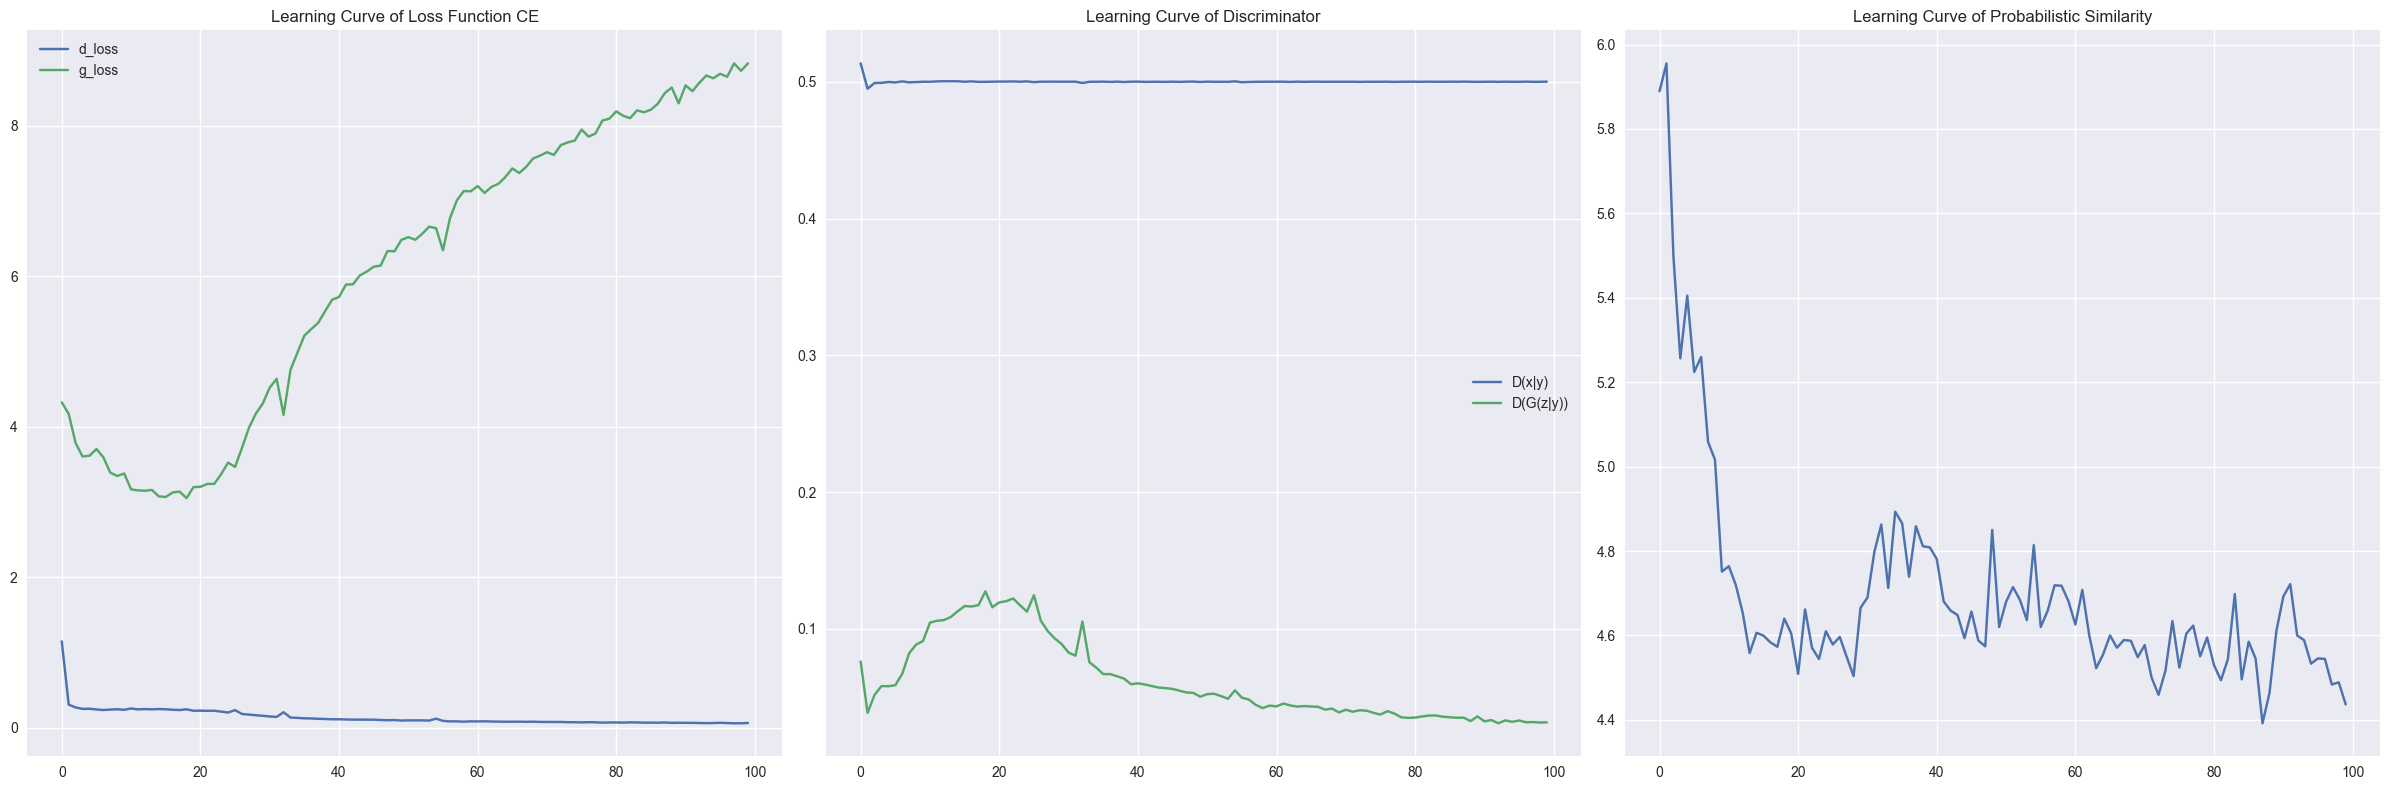

In [ ]:
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

## Evaluation using Fréchet Inception Distance (FID)


In [ ]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import math
from tqdm import tqdm
from tensorflow.image import resize
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
full_train = np.concatenate((x_train, x_val), axis=0)
fid_class.fit(generator=aux_cond_gan.generator, train_data=full_train)
fid_score = fid_class.evaluate()


Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 7s 156ms/step


  5%|▌         | 1/20 [00:10<03:11, 10.08s/it]

16/16 [==============================] - 3s 152ms/step


 10%|█         | 2/20 [00:15<02:09,  7.17s/it]

16/16 [==============================] - 3s 152ms/step


 15%|█▌        | 3/20 [00:19<01:43,  6.06s/it]

16/16 [==============================] - 3s 154ms/step


 20%|██        | 4/20 [00:25<01:31,  5.69s/it]

16/16 [==============================] - 3s 153ms/step


 25%|██▌       | 5/20 [00:29<01:20,  5.36s/it]

16/16 [==============================] - 3s 155ms/step


 30%|███       | 6/20 [00:34<01:11,  5.14s/it]

16/16 [==============================] - 3s 154ms/step


 35%|███▌      | 7/20 [00:39<01:07,  5.20s/it]

16/16 [==============================] - 3s 146ms/step


 40%|████      | 8/20 [00:45<01:02,  5.22s/it]

16/16 [==============================] - 2s 152ms/step


 45%|████▌     | 9/20 [00:49<00:55,  5.05s/it]

16/16 [==============================] - 2s 147ms/step


 50%|█████     | 10/20 [00:54<00:48,  4.80s/it]

16/16 [==============================] - 2s 145ms/step


 55%|█████▌    | 11/20 [00:57<00:40,  4.48s/it]

16/16 [==============================] - 2s 145ms/step


 60%|██████    | 12/20 [01:01<00:34,  4.35s/it]

16/16 [==============================] - 2s 146ms/step


 65%|██████▌   | 13/20 [01:05<00:29,  4.24s/it]

16/16 [==============================] - 2s 147ms/step


 70%|███████   | 14/20 [01:09<00:23,  3.99s/it]

16/16 [==============================] - 2s 148ms/step


 75%|███████▌  | 15/20 [01:12<00:19,  3.81s/it]

16/16 [==============================] - 2s 147ms/step


 80%|████████  | 16/20 [01:16<00:14,  3.71s/it]

16/16 [==============================] - 2s 148ms/step


 85%|████████▌ | 17/20 [01:19<00:10,  3.66s/it]

16/16 [==============================] - 2s 146ms/step


 90%|█████████ | 18/20 [01:23<00:07,  3.68s/it]

16/16 [==============================] - 2s 147ms/step


 95%|█████████▌| 19/20 [01:26<00:03,  3.61s/it]

16/16 [==============================] - 2s 147ms/step


100%|██████████| 20/20 [01:30<00:00,  4.52s/it]

Computing Generated Image Embeddings



  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 2s 153ms/step


  5%|▌         | 1/20 [00:04<01:30,  4.78s/it]

16/16 [==============================] - 3s 163ms/step


 10%|█         | 2/20 [00:08<01:17,  4.29s/it]

16/16 [==============================] - 2s 148ms/step


 15%|█▌        | 3/20 [00:12<01:06,  3.93s/it]

16/16 [==============================] - 2s 148ms/step


 20%|██        | 4/20 [00:15<00:59,  3.75s/it]

16/16 [==============================] - 2s 146ms/step


 25%|██▌       | 5/20 [00:19<00:55,  3.69s/it]

16/16 [==============================] - 2s 148ms/step


 30%|███       | 6/20 [00:22<00:50,  3.59s/it]

16/16 [==============================] - 2s 148ms/step


 35%|███▌      | 7/20 [00:26<00:46,  3.55s/it]

16/16 [==============================] - 2s 147ms/step


 40%|████      | 8/20 [00:29<00:42,  3.53s/it]

16/16 [==============================] - 2s 146ms/step


 45%|████▌     | 9/20 [00:33<00:39,  3.57s/it]

16/16 [==============================] - 2s 148ms/step


 50%|█████     | 10/20 [00:36<00:35,  3.56s/it]

16/16 [==============================] - 2s 147ms/step


 55%|█████▌    | 11/20 [00:40<00:33,  3.68s/it]

16/16 [==============================] - 2s 148ms/step


 60%|██████    | 12/20 [00:44<00:30,  3.76s/it]

16/16 [==============================] - 2s 148ms/step


 65%|██████▌   | 13/20 [00:48<00:25,  3.69s/it]

16/16 [==============================] - 2s 149ms/step


 70%|███████   | 14/20 [00:52<00:22,  3.79s/it]

16/16 [==============================] - 2s 149ms/step


 75%|███████▌  | 15/20 [00:56<00:19,  3.99s/it]

16/16 [==============================] - 2s 146ms/step


 80%|████████  | 16/20 [01:00<00:15,  3.90s/it]

16/16 [==============================] - 3s 152ms/step


 85%|████████▌ | 17/20 [01:04<00:12,  4.06s/it]

16/16 [==============================] - 2s 149ms/step


 90%|█████████ | 18/20 [01:08<00:07,  3.85s/it]

16/16 [==============================] - 3s 156ms/step


 95%|█████████▌| 19/20 [01:12<00:04,  4.02s/it]

16/16 [==============================] - 2s 147ms/step


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]

Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape


The computed FID score is: 581.1935628265244


In [12]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [15]:
# import module
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# load trained network
path = "./model/acgan/generator-epoch-Full Train.h5"
resnet34 = load_model(path)

# Validating Model is accurate
train_loss, train_acc = resnet34.evaluate(x_train, np.argmax(y_train, axis=1))
test_loss, test_acc = resnet34.evaluate(x_test, np.argmax(y_test, axis=1))

#  Assert Statements
assert train_acc >= 0.9, "Train Accuracy falls below 90%"
assert test_acc >= 0.9, "Test Accuracy falls below 90%"

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000002741D977550>.

In [ ]:
# creating conditions and noise input
n_size = 1000
conditions = np.full(int(n_size/10), 0)
for i in range(9):
    conditions = np.concatenate([conditions, np.full(int(n_size/10), i+1)])
conditions = to_categorical(conditions)
latent_noise_vector = tf.random.normal(shape=(n_size, latent_dim))

# generate iamges
synthetic_imgs = cond_gan.generator.predict([latent_noise_vector, conditions])

# create predictions
predictions = resnet34.predict(synthetic_imgs)

In [ ]:
# classification report
c_report = classification_report(np.argmax(conditions, axis=1), np.argmax(predictions, axis=1), target_names=classes.values())
print(c_report)

In [ ]:
# compute confusion matrix
cm = confusion_matrix(np.argmax(conditions, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(12, 6), tight_layout=True)
sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=classes.values(), yticklabels=classes.values(), fmt='.3g')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# AC-BIGAN

# Trying out with upsampling and BatchNorm


In [ ]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)
        model.summary()
        return Model(noise, img)

In [ ]:
plot_model(build_generator())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_474 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 batch_normalization_478 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 activation_470 (Activation)  (None, 16, 16, 128)      0

In [ ]:
def build_discriminator():
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32,32,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=(32,32,3))
        validity = model(img)
        model.summary()
        return Model(img, validity)

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_477 (Conv2D)         (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_478 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_480 (Ba  (None, 9, 9, 64)         256       
 tchNormalization)                                    

### Evaluation using Fréchet Inception Distance (FID)

In [ ]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import math
from tqdm import tqdm
from tensorflow.image import resize
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
combined.layers[1].get_config()

{'name': 'model_2',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_8'},
   'name': 'input_8',
   'inbound_nodes': []},
  {'class_name': 'Sequential',
   'config': {'name': 'sequential_2',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 128),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'dense_4_input'}},
     {'class_name': 'Dense',
      'config': {'name': 'dense_4',
       'trainable': True,
       'batch_input_shape': (None, 128),
       'dtype': 'float32',
       'units': 8192,
       'activation': 'relu',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': None}},
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'kernel_regularizer': None,
       'bias_regularizer': None,
       'activity

In [ ]:
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
#fit to the generator 
fid_class.fit(generator=combined, train_data=x_train)
fid_score = fid_class.evaluate()


ValueError: Layer "model_3" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(10000, 128), dtype=float32, numpy=
array([[-0.12368795,  0.18335691, -0.8162616 , ...,  0.8640542 ,
         0.35710666, -0.27165708],
       [-0.3944097 , -0.8422722 , -0.29390585, ...,  0.04192879,
        -1.5127047 ,  0.46348646],
       [ 0.54553235, -0.54945934, -0.8004057 , ..., -0.9632256 ,
         0.05892894,  0.27323833],
       ...,
       [ 0.75050974,  0.05453695, -0.4130569 , ..., -1.1330073 ,
        -0.03901747,  0.92500037],
       [ 0.44335657,  0.91639584, -0.9916518 , ...,  1.523942  ,
         0.01963829,  0.8772075 ],
       [ 0.37495926, -0.22167423,  0.05321196, ..., -0.280089  ,
        -0.15746556,  0.7422195 ]], dtype=float32)>, <tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>]

# Trying with data augmentation